In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import os

C:\Users\shubh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PES1UG20CS420 Shubham S
# PES1UG20CS421 Shuchith B U
# PES1UG20CS423 Siddarth M P
# PES1UG20CS625 Amogh N Rao

In [2]:
%python -m spacy download en_core_web_sm

UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [3]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

# Some Context about the book
### "The Witcher: Blood of Elves" is the first full-length novel in the Witcher series by Andrzej Sapkowski. The story follows the Witcher Geralt of Rivia as he takes in the orphaned princess Ciri, who possesses magical powers and is pursued by various factions who seek to use her for their own gain. Geralt must navigate political intrigue, magical threats, and the training of Ciri while also dealing with the internal conflicts of his own kind, the Witchers. The novel explores themes of destiny, family, and the consequences of power.

In [4]:
book_text = open("Team3_420_421_423_625.txt").read()
book_doc = NER(book_text)

We can visualize Entities through SpaCy's built in visualization suite for dependencies and named entities.


A useful tool which we thought was relevent to show

In [5]:
# Visualize identified entities
displacy.render(book_doc[0:100], style="ent", jupyter=True)

## Section 1.a
## Load character names

Essentially we have identified all the relevent characters by scarping the fandom wiki website of The Witcher Novels

Now This may seem a lot of characters for now but instead of us choosing the "Essential" characters by our own subjective opinion, we've decided to prune the character list after finding the centrality values of all of them and taking only the top ones to build all our graphs

In [6]:
character=['Abrad the Old Oak',
'Aelirenn',
'Agnes of Glanville',
'Anna Tiller',
'AnsÃ©is',
'Artaud Terranova',
'Axel Esparza',
'Boatbug',
'Boratek',
'Bronibor',
'Cahir Mawr Dyffryn aep Ceallach',
'Calanthe',
'Carduin',
'Carla Demetia Crest',
'Ciri',
'CoÃ«n',
'Crach an Craite',
'Dandelion',
'Demavend III',
'Dezmod',
'Donimir of Troy',
'Duke de Ruyter',
'Edmund Bumbler',
'Eist Tuirseach',
'Ekkehard of Sodden',
'Emhyr var Emreis',
'Ervyll',
'Eskel',
'Essi Daven',
'Esterad Thyssen',
'Ethain',
'Eurneid',
'Everett',
'Fercart',
'Flavius Michelet',
'Foltest',
'Francesca Findabair',
'Geoffrey Monck',
'Geralt of Rivia',
'Gerhart of Aelle',
'Giambattista',
'Griffin of Temeria',
'Gruzila',
'Henselt',
'Herbert Stammelford',
'Hereward',
'Hrosvitha',
'Iola',
'Iola the Second',
'Ironware',
'Ithlinne',
'Ivo Richert',
'Jan Bekker',
'Jarre',
'Katje',
'Keira Metz',
'Kistrin',
'Lambert',
'Linus Pitt',
'Lodovico Michelet',
'Lucas Corto',
'Lydia van Bredevoort',
'Lytta Neyd',
'Mama Lantieri',
'Maria Louisa La Valette',
'Marquis La Creahme',
'Medell',
'Menno Coehoorn',
'Meve',
'Michelet brothers',
'Milan Raupenneck',
'Myhrman',
'Myrrha',
'Nenneke',
'Nicodemus de Boot',
'Niedamir',
'Old Baron La Valette',
'Olsen',
'Ori Reuven',
'Paulie Dahlberg',
'Pavetta',
'Pelligram',
'Philippa Eilhart',
'Podveyka',
'Radcliffe',
'Radovid I',
'Radovid III',
'Rayla',
'Regan Dahlberg',
'Reginald',
'Rience',
'Rizzi Michelet',
'Roach',
'Sambuk',
'Schrader',
'Shani',
'Sheldon Skaggs',
'Sigismund Dijkstra',
'Stran',
'Tissaia de Vries',
'Toublanc Michelet',
'Triss Merigold',
'Unist',
'Vanielle',
'Venzlav',
'Vera Loewenhaupt',
'Vesemir',
'Vilfrid Wenck',
'Vilgefortz',
'Villem',
'Virfuril',
'Vissegerd',
'Vitek',
'Vizimir II',
'Windhalm of Attre',
'Wolfgang Amadeus Goatbeard',
'Xavier Moran',
'Yannick Brass',
'Yarpen Zigrin',
'Yennefer of Vengerberg',
'YoÃ«l Grethen',
'Zyvik']

In [7]:
character_df = pd.DataFrame(character,columns=['character'])

In [8]:
# Remove brackets and text within brackets
import re 
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [9]:
pd.set_option('display.max_rows', None)
character_df.head(10)

character character_firstname
0   Abrad the Old Oak               Abrad
1            Aelirenn            Aelirenn
2  Agnes of Glanville               Agnes
3         Anna Tiller                Anna
4             AnsÃ©is             AnsÃ©is
5    Artaud Terranova              Artaud
6        Axel Esparza                Axel
7             Boatbug             Boatbug
8             Boratek             Boratek
9            Bronibor            Bronibor

## Section 1.b

## Preparing the Social Graph
 Get named entity list per sentence

In [10]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [11]:
sent_entity_df.head(10)

sentence  \
0  (ï»¿Verily, I, say, unto, you, ,, the, era, of...   
1  (The, Time, \n, of, the, White, Chill, and, th...   
2  (The, world, will, die, amidst, frost, and, be...   
3  (It, will, be, reborn, of, the, Elder, Blood, ...   
4  (A, seed, which, \n, will, not, sprout, but, w...   
5                               (Ess'tuath, esse, !)   
6                           (Thus, it, shall, be, !)   
7                        (Watch, for, the, signs, !)   
8  (What, signs, these, shall, be, ,, I, say, unt...   
9                (The, town, was, in, flames, ., \n)   

                                            entities  
0                                             [wolf]  
1  [Time, the White Chill, the White Light, the T...  
2                                                 []  
3                      [the Elder Blood, Hen Ichaer]  
4                                                 []  
5                                                 []  
6                                                 []  
7                                                 []  
8  [first, earth, Aen Seidhe, the Blood of Elves,...  
9                                                 []

In [12]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [13]:
filter_entity(["Geralt", "Thu", "2"], character_df)

['Geralt']

In [14]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

sentence      entities  \
14   (Ciri, felt, the, knight, who, carried, her, b...        [Ciri]   
18   (Ciri, caught, a, glimpse, of, the, skirmish, ...        [Ciri]   
64   (Ciri, sees, his, eyes, gleaming, through, the...  [Ciri, prey]   
67                     (Ciri, is, unable, to, move, .)        [Ciri]   
70   (And, she, is, frozen, in, fear, :, a, terribl...        [Ciri]   
130  (Ciri, sees, his, eyes, gleaming, through, the...  [Ciri, prey]   
133                    (Ciri, is, unable, to, move, .)        [Ciri]   
136  (And, she, is, frozen, in, fear, :, a, terribl...        [Ciri]   
163  (Ciri, shuddered, violently, ,, curling, her, ...        [Ciri]   
167  (', Geralt, ,, I-, ', \n, ', I, 'm, right, her...      [Geralt]   

    character_entities  
14              [Ciri]  
18              [Ciri]  
64              [Ciri]  
67              [Ciri]  
70              [Ciri]  
130             [Ciri]  
133             [Ciri]  
136             [Ciri]  
163             [Ciri]  
167           [Geralt]

In [15]:
# Take only first name of characters
import warnings
warnings.filterwarnings("ignore")
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])

In [16]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered.head(15)

sentence  \
14   (Ciri, felt, the, knight, who, carried, her, b...   
18   (Ciri, caught, a, glimpse, of, the, skirmish, ...   
64   (Ciri, sees, his, eyes, gleaming, through, the...   
67                     (Ciri, is, unable, to, move, .)   
70   (And, she, is, frozen, in, fear, :, a, terribl...   
130  (Ciri, sees, his, eyes, gleaming, through, the...   
133                    (Ciri, is, unable, to, move, .)   
136  (And, she, is, frozen, in, fear, :, a, terribl...   
163  (Ciri, shuddered, violently, ,, curling, her, ...   
167  (', Geralt, ,, I-, ', \n, ', I, 'm, right, her...   
178  (Geralt, of, Rivia, ,, the, White, Wolf, ,, an...   
183  (Hold, ..., \n, ', Geralt, ?, ', \n, ', What, ...   
197  (Ciri, had, been, frightened, of, them, ,, she...   
204  (Ciri, had, heard, such, reassurances, in, the...   
208  (Because, it, was, Geralt, of, Rivia, ,, the, ...   

                              entities character_entities  
14                              [Ciri]             [Ciri]  
18                              [Ciri]             [Ciri]  
64                        [Ciri, prey]             [Ciri]  
67                              [Ciri]             [Ciri]  
70                              [Ciri]             [Ciri]  
130                       [Ciri, prey]             [Ciri]  
133                             [Ciri]             [Ciri]  
136                             [Ciri]             [Ciri]  
163                             [Ciri]             [Ciri]  
167                           [Geralt]           [Geralt]  
178  [Geralt of Rivia, the White Wolf]           [Geralt]  
183                           [Geralt]           [Geralt]  
197                             [Ciri]             [Ciri]  
204                             [Ciri]             [Ciri]  
208  [Geralt of Rivia, the White Wolf]           [Geralt]

## Create relationships

In [17]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [18]:
relationship_df = pd.DataFrame(relationships)

In [19]:
pd.set_option('display.max_rows', None)
relationship_df.head(15)

source     target
0       Ciri     Geralt
1       Ciri     Geralt
2       Ciri     Geralt
3       Ciri     Geralt
4     Geralt   Yennefer
5     Geralt   Yennefer
6     Geralt   Yennefer
7     Geralt   Yennefer
8   Yennefer  Dandelion
9     Geralt   Yennefer
10  Yennefer  Dandelion
11    Geralt   Yennefer
12  Yennefer  Dandelion
13   Sheldon    Donimir
14   Sheldon    Donimir

In [20]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df.head(15)

source    target
0        Ciri    Geralt
1        Ciri    Geralt
2        Ciri    Geralt
3        Ciri    Geralt
4      Geralt  Yennefer
5      Geralt  Yennefer
6      Geralt  Yennefer
7      Geralt  Yennefer
8   Dandelion  Yennefer
9      Geralt  Yennefer
10  Dandelion  Yennefer
11     Geralt  Yennefer
12  Dandelion  Yennefer
13    Donimir   Sheldon
14    Donimir   Sheldon

In [21]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

###  We've taken the top 100 relationships (edges) from our trials of taking different top k edges, we've observed that 100 seems to capture the top characters of the story (without any irrelevent placeholder characters) while at the same time retain enough information of the story as we've understood it

In [22]:
r = relationship_df.sort_values(by=['value'],ascending=False).head(100)
r

source      target  value
36         Ciri    Yennefer    336
0          Ciri      Geralt    297
24       Geralt       Triss    187
1        Geralt    Yennefer    128
45       Geralt      Yarpen    124
23         Ciri       Triss    118
55         Ciri      Yarpen    102
22       Geralt     Vesemir     93
177        Ciri       Jarre     88
21         Ciri     Vesemir     76
178        Ciri     Nenneke     72
161       Lydia  Vilgefortz     53
183     Nenneke    Yennefer     47
5     Dandelion      Geralt     47
17         Ciri       Eskel     44
85      Boatbug      Geralt     41
27       Geralt     Lambert     41
28         Ciri     Lambert     40
30      Lambert       Triss     40
20      Lambert     Vesemir     38
61       Paulie      Yarpen     37
63        Regan      Yarpen     36
159     Tissaia  Vilgefortz     36
106      Geralt    Philippa     35
88       Geralt       Olsen     34
79      Everett      Geralt     33
29        Triss     Vesemir     32
102   Dandelion       Shani     32
59       Geralt       Roach     30
117     Henselt     Vizimir     30
108      Geralt       Shani     29
19        Eskel     Vesemir     29
122       Emhyr     Foltest     28
158      Artaud     Tissaia     27
26        Eskel      Geralt     26
48       Paulie       Regan     23
32        Eskel     Lambert     23
134     Foltest   Vissegerd     22
41      Fercart    Yennefer     22
16         Ciri       Roach     22
120        Meve     Vizimir     22
104      Geralt      Rience     22
105   Dandelion    Philippa     22
133       Emhyr   Vissegerd     22
90      Boatbug       Olsen     21
31        Triss    Yennefer     21
70     Aelirenn        Ciri     20
89      Everett       Olsen     20
160      Artaud       Lydia     18
109    Philippa       Shani     18
115     Foltest     Vizimir     17
7          Ciri     Pavetta     17
25        Eskel       Triss     17
54        Triss      Yarpen     17
167     Tissaia    Yennefer     16
81       Geralt     Nenneke     16
52       Geralt     Vilfrid     16
118       Emhyr     Vizimir     16
86       Geralt       Linus     16
39       Artaud  Vilgefortz     16
116     Foltest     Henselt     15
80         Ciri        Iola     14
119       Emhyr     Henselt     13
66       Geralt      Paulie     13
121       Emhyr        Meve     13
124     Henselt        Meve     12
92        Linus       Olsen     12
110    Philippa    Yennefer     12
96        Stran       Vitek     12
127     Esterad    Niedamir     12
166      Artaud    Yennefer     11
2     Dandelion    Yennefer     11
143      Medell    Virfuril     11
71     Aelirenn      Geralt     10
131     Foltest  Vilgefortz     10
62       Xavier      Yarpen     10
13    Dandelion      Rience     10
149     Myhrman       Shani     10
18        Eskel       Roach     10
179       Jarre     Nenneke      9
91      Boratek       Olsen      9
47       Paulie      Xavier      9
60       Yarpen    Yennefer      9
42     Vanielle    Yennefer      9
93      Boatbug       Linus      9
181       Jarre    Yennefer      9
94      Boatbug     Everett      8
114    Philippa      Rience      8
74      Yannick      Yarpen      8
164  Vilgefortz    Yennefer      8
14       Rience    Yennefer      7
192        Ciri   Francesca      7
135        Meve   Vissegerd      7
169      Geralt     Tissaia      7
4        Geralt        Vera      7
185   Hrosvitha     Nenneke      6
46       Xavier     Yannick      6
156     Myhrman      Rience      6
155     Flavius    Toublanc      6
171        Ciri    Philippa      6

## Graph analysis and visualization

In [23]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(r, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

#### Graph visualization - Networkx

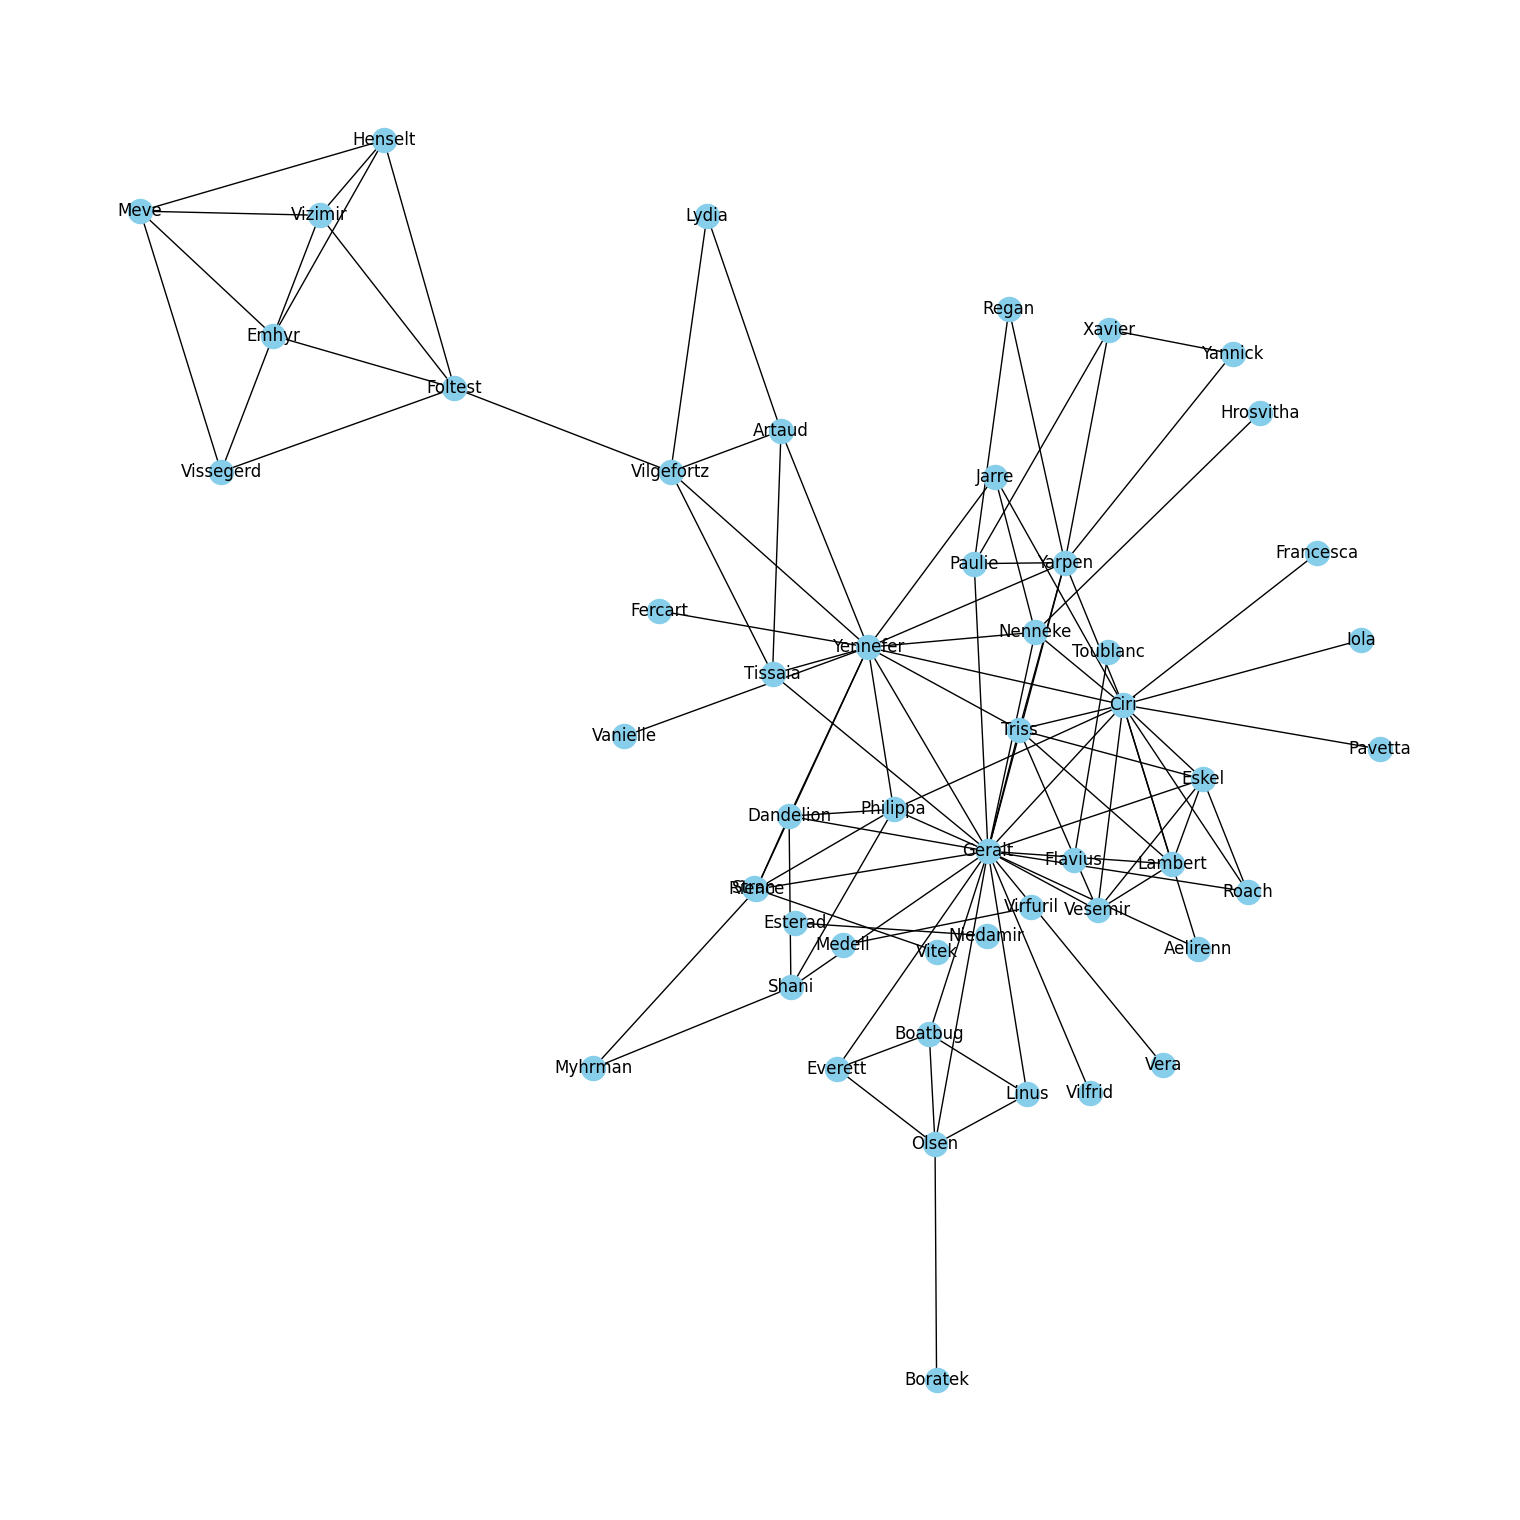

In [24]:
plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# Section 2d

#### Graph visualization - Pyvis

This visualization did not open in the downloaded version of our Colab for some reason but the Screenshot of it has been inserted here

In [25]:
# from pyvis.network import Network
# net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)
# print(node_degree)
# #Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

nx.write_gexf(G, "witcher_characters.gexf")

# net.from_nx(G)
# net.show("witcher.html")

![Alt text](data/Flonnect_2023-03-10_bd86a7d2-fe75-4eb4-8c0c-c34a011f889f-trim-1.gif)

![Alt text](data/Flonnect_2023-03-10_86e7e6ae-d9be-44e4-8b27-96db7f903fea-trim-2.gif)

In [26]:
s='\n The graph details: '
print (s)


a=G.number_of_nodes()
s='\n The no of nodes: ' +repr(a)

a=G.number_of_nodes()
s='\n The no of nodes: ' +repr(a)

a=G.number_of_nodes()
s='\n The no of nodes: ' +repr(a)
print (s)

a= G.number_of_edges()
s='\n The no of edges: ' +repr(a)
print (s)

deg=nx.degree(G)
a= min(deg)
s='\n The min degree: ' +repr(a)
print (s)

a = max(deg)
s='\n The max degree: ' +repr(a)
print (s)




 The graph details: 

 The no of nodes: 52

 The no of edges: 100

 The min degree: ('Aelirenn', 2)

 The max degree: ('Yennefer', 14)


## Section 1.c 
#### Degree Centrality:

In [27]:
from operator import itemgetter
degc = nx.degree_centrality(G)
# let's list the scores
pd.DataFrame(sorted(degc.items(), key=itemgetter(1), reverse=True)).head(20)

0         1
0       Geralt  0.431373
1         Ciri  0.294118
2     Yennefer  0.274510
3       Yarpen  0.156863
4        Triss  0.137255
5        Eskel  0.117647
6     Philippa  0.117647
7      Vesemir  0.098039
8      Nenneke  0.098039
9   Vilgefortz  0.098039
10   Dandelion  0.098039
11     Lambert  0.098039
12       Olsen  0.098039
13       Emhyr  0.098039
14     Foltest  0.098039
15      Rience  0.098039
16     Boatbug  0.078431
17      Paulie  0.078431
18     Tissaia  0.078431
19       Shani  0.078431

<AxesSubplot: >

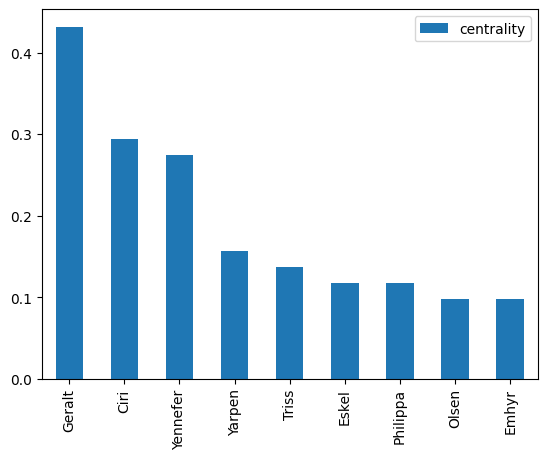

In [28]:
degree_df = pd.DataFrame.from_dict(degc, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

# Betweeness Centrality :

In [29]:
bet = nx.betweenness_centrality(G)
# let's list the scores
pd.DataFrame(sorted(bet.items(), key=itemgetter(1), reverse=True)).head(20)

0         1
0       Geralt  0.323046
1     Yennefer  0.268706
2   Vilgefortz  0.187843
3      Foltest  0.149542
4         Ciri  0.138157
5       Yarpen  0.086484
6      Tissaia  0.042353
7      Nenneke  0.035320
8        Olsen  0.033203
9       Rience  0.022431
10      Artaud  0.013725
11      Paulie  0.013046
12       Triss  0.010392
13       Shani  0.009725
14       Emhyr  0.008170
15    Philippa  0.007922
16     Henselt  0.007647
17     Vizimir  0.007647
18   Vissegerd  0.007647
19   Dandelion  0.002876

<AxesSubplot: >

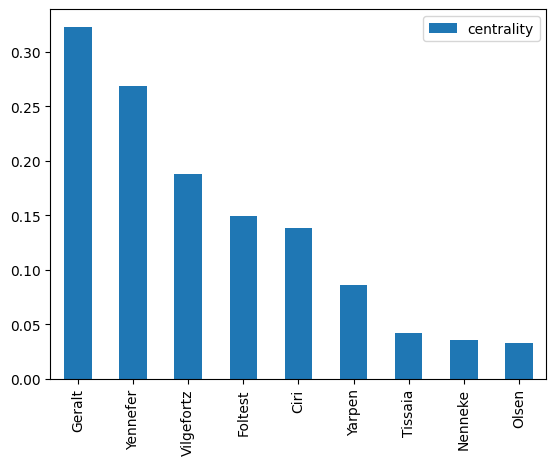

In [30]:

betweenness_df = pd.DataFrame.from_dict(bet, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

# Closeness Centrality:

In [31]:
clos = nx.closeness_centrality(G)
# let's list the scores
pd.DataFrame(sorted(clos.items(), key=itemgetter(1), reverse=True)).head(20)

0         1
0       Geralt  0.470843
1     Yennefer  0.458923
2         Ciri  0.421569
3       Yarpen  0.385690
4        Triss  0.381631
5      Tissaia  0.373762
6     Philippa  0.369948
7      Nenneke  0.366211
8    Dandelion  0.355440
9       Rience  0.355440
10  Vilgefortz  0.345285
11       Jarre  0.329590
12       Eskel  0.329590
13     Vesemir  0.326621
14     Lambert  0.326621
15      Artaud  0.326621
16      Paulie  0.320840
17       Roach  0.320840
18       Olsen  0.318025
19    Aelirenn  0.318025

<AxesSubplot: >

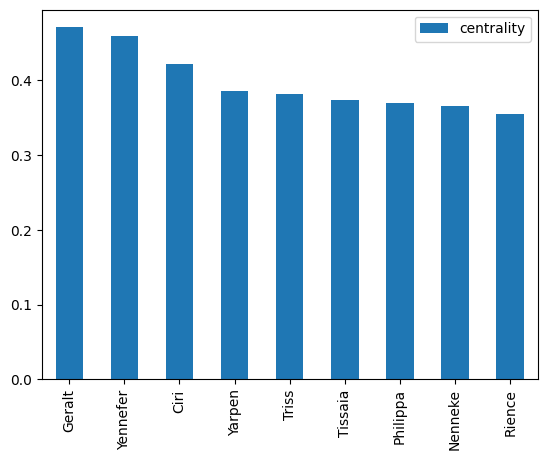

In [32]:

closeness_df = pd.DataFrame.from_dict(clos, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

# PageRank Centrality:

In [33]:
pgr=nx.pagerank(G)
pd.DataFrame(sorted(pgr.items(), key=itemgetter(1), reverse=True)).head(20)


0         1
0       Geralt  0.086619
1         Ciri  0.061664
2     Yennefer  0.056730
3       Yarpen  0.033466
4        Triss  0.026695
5        Olsen  0.024167
6     Philippa  0.023838
7        Eskel  0.023323
8      Nenneke  0.022797
9        Emhyr  0.022619
10     Foltest  0.022450
11  Vilgefortz  0.022186
12      Rience  0.020794
13   Dandelion  0.020274
14     Vesemir  0.019603
15     Lambert  0.019603
16       Stran  0.019231
17       Vitek  0.019231
18     Esterad  0.019231
19    Niedamir  0.019231

<AxesSubplot: >

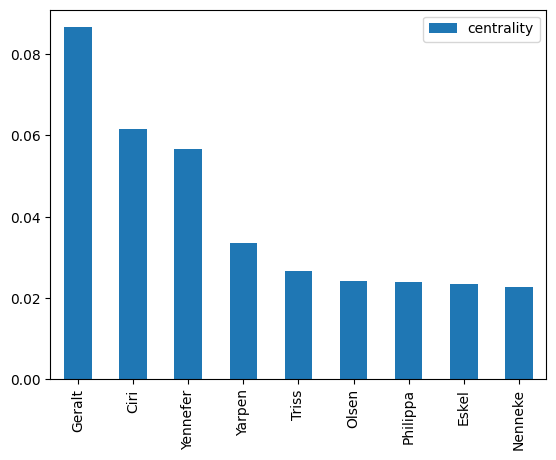

In [34]:
pgr_df = pd.DataFrame.from_dict(pgr, orient='index', columns=['centrality'])
# Plot top 10 nodes
pgr_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

# Compare Centralities:

Text(0.5, 1.0, 'Betweenness Centrality')

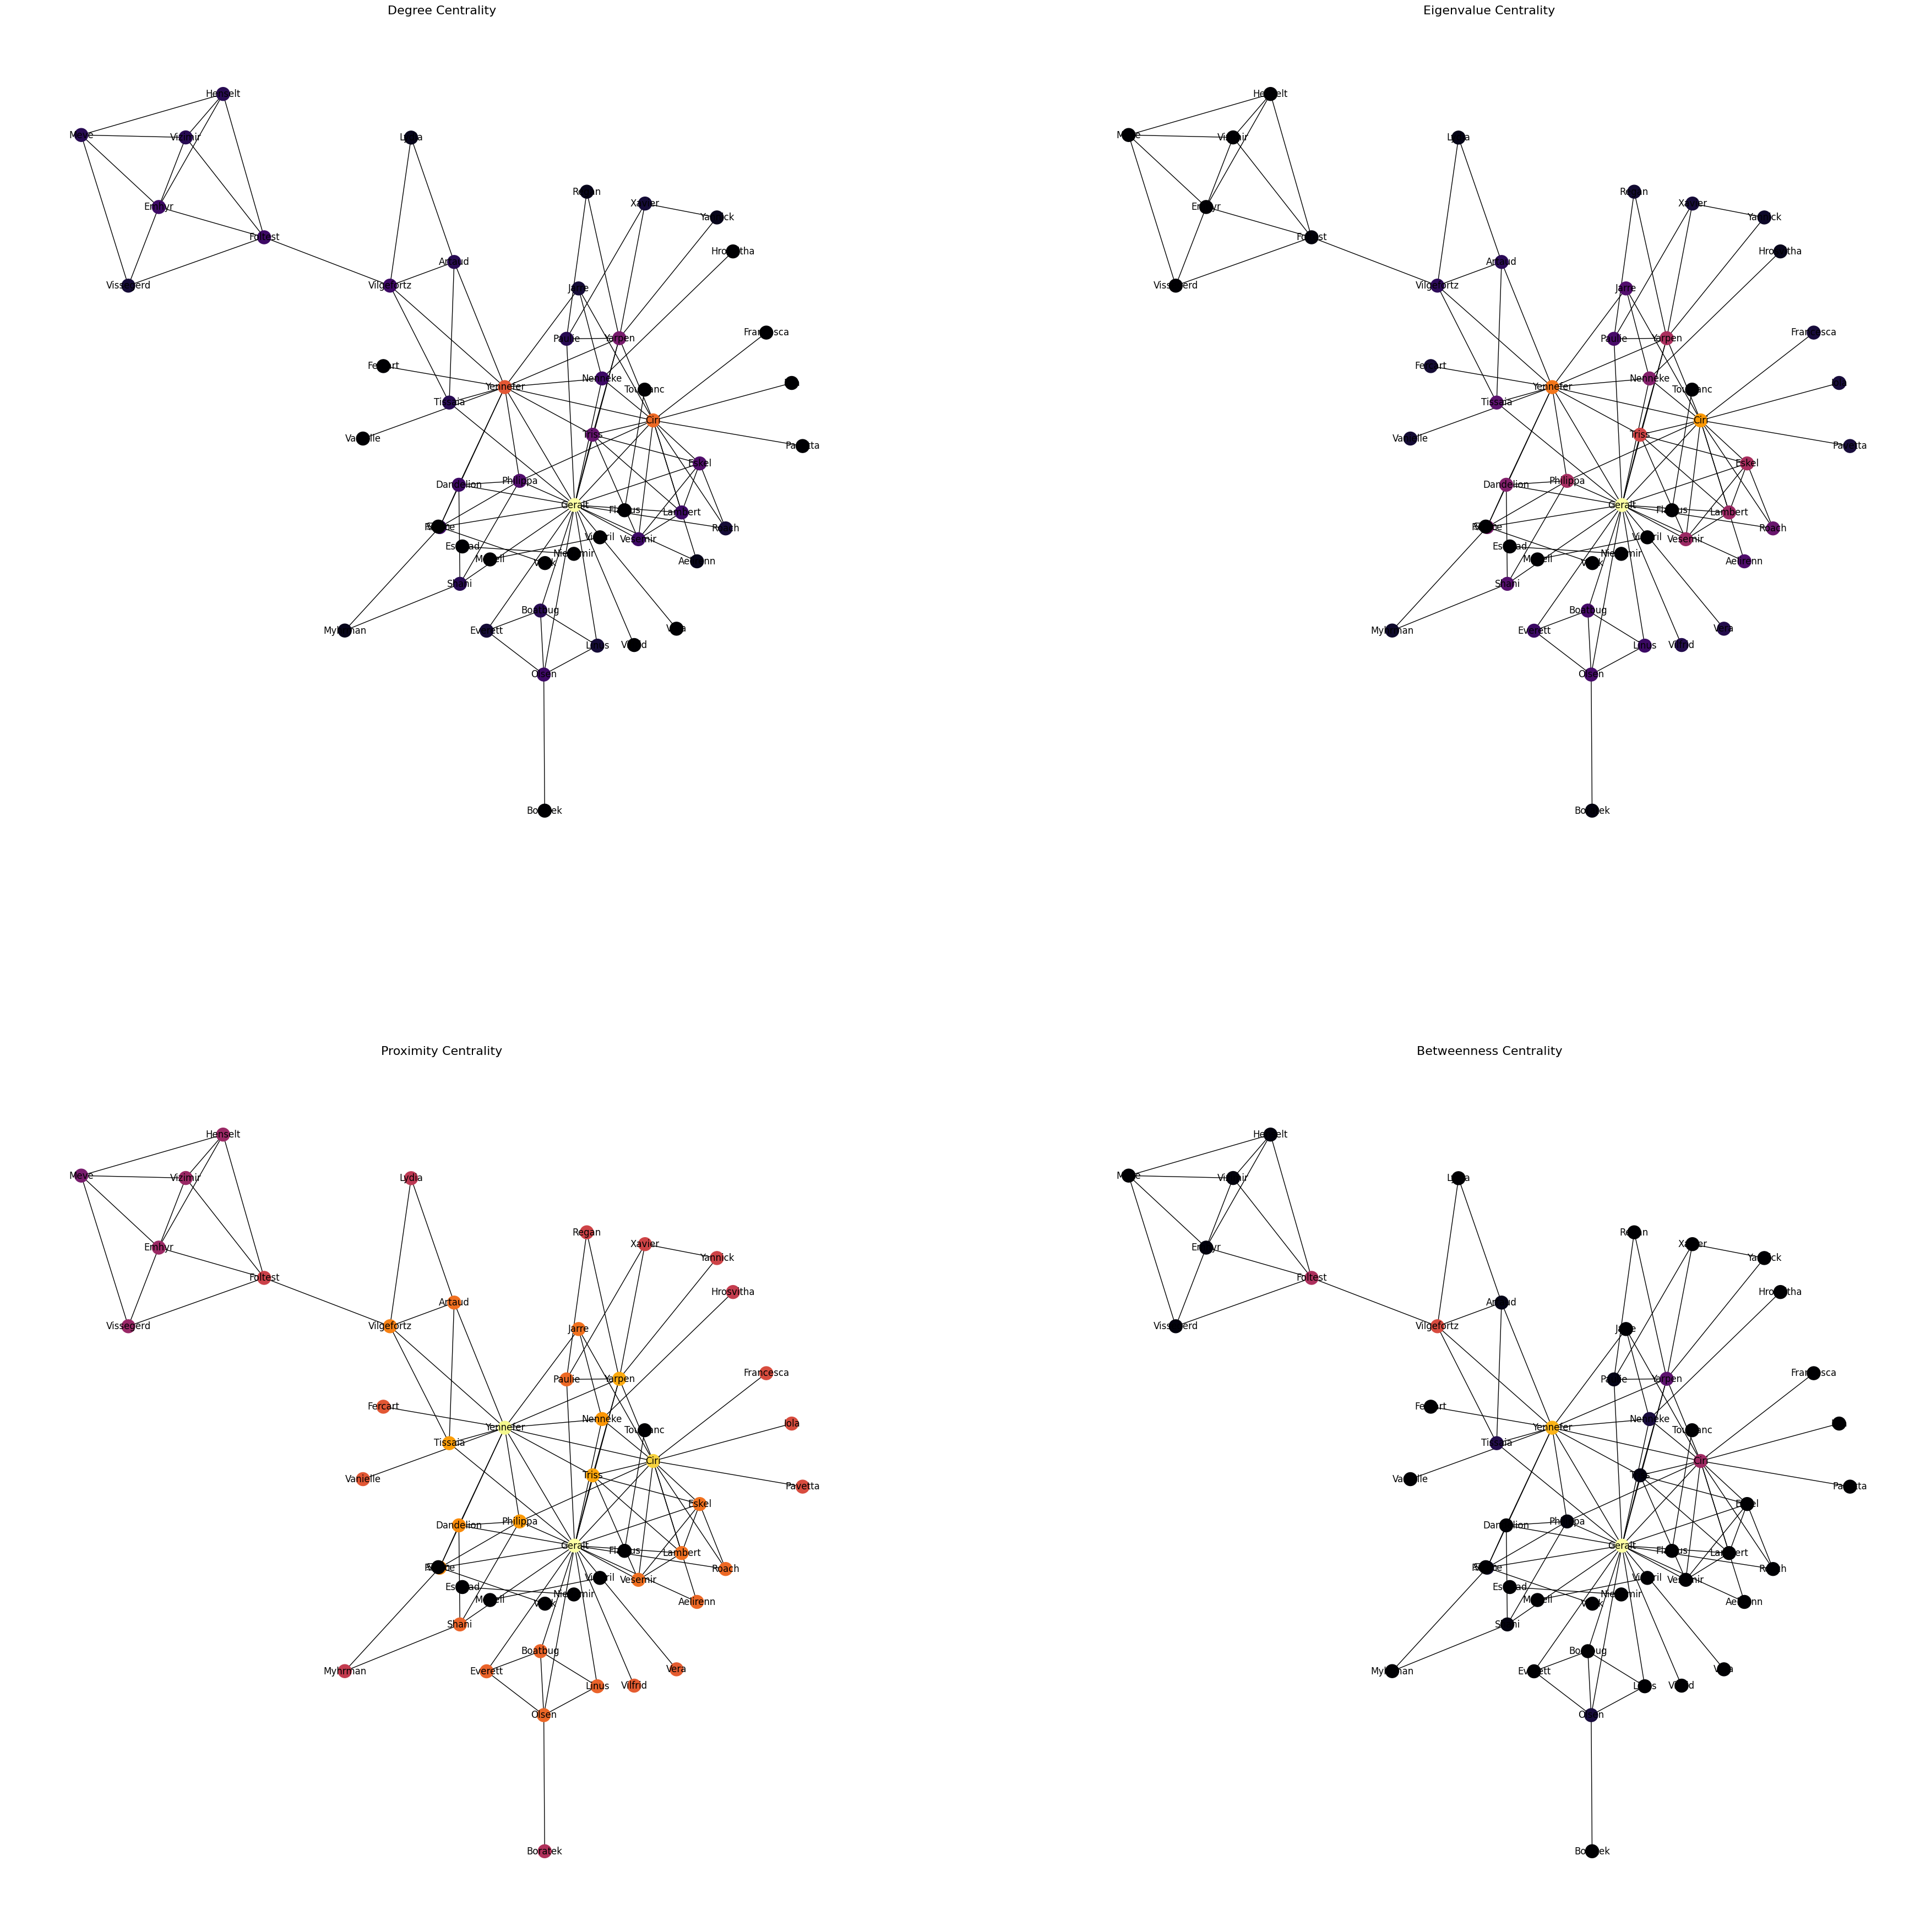

In [35]:
c_degree = nx.degree_centrality(G)
c_degree = list(c_degree.values())

c_eigenvector = nx.eigenvector_centrality(G)
c_eigenvector = list(c_eigenvector.values())

c_closeness = nx.closeness_centrality(G)
c_closeness = list(c_closeness.values())

c_betweenness = nx.betweenness_centrality(G)
c_betweenness = list(c_betweenness.values())

# Plot the centrality of the nodes
plt.figure(figsize=(45, 45))
# Degree Centrality
f, axarr = plt.subplots(2, 2, num=1)
plt.sca(axarr[0,0])
nx.draw(G, cmap = plt.get_cmap('inferno'), node_color = c_degree, node_size=300, pos=pos, with_labels=True)
axarr[0,0].set_title('Degree Centrality', size=16)
# Eigenvalue Centrality
plt.sca(axarr[0,1])
nx.draw(G, cmap = plt.get_cmap('inferno'), node_color = c_eigenvector, node_size=300, pos=pos, with_labels=True)
axarr[0,1].set_title('Eigenvalue Centrality', size=16)
# Closeness Centrality
plt.sca(axarr[1,0])
nx.draw(G, cmap = plt.get_cmap('inferno'), node_color = c_closeness, node_size=300, pos=pos, with_labels=True)
axarr[1,0].set_title('Proximity Centrality', size=16)
# Betweenness Centrality
plt.sca(axarr[1,1])
nx.draw(G, cmap = plt.get_cmap('inferno'), node_color = c_betweenness, node_size=300, pos=pos, with_labels=True)
axarr[1,1].set_title('Betweenness Centrality', size=16)


# Centrality Scatter plot 

In [36]:
#Centrality scatter plot 
def centrality_scatter(dict1,dict2,path="",ylab="",xlab="",title="",line=False):
    # Create figure and drawing axis
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    # Create items and extract centralities
    items1 = sorted(dict1.items())
    items2 = sorted(dict2.items())
    xdata=[b for a,b in items1]
    ydata=[b for a,b in items2]
    # Add each actor to the plot by ID
    for p in range(len(items1)):
        ax1.text(x=xdata[p], y=ydata[p],s=str(items1[p][0]), color="b")
        if line:
            # use NumPy to calculate the best fit
            slope, yint = plt.polyfit(xdata,ydata,1)
            xline = plt.xticks()[0]
            yline = map(lambda x: slope*x+yint,xline)
            ax1.plot(xline,yline,ls='--',color='b')
        # Set new x- and y-axis limits
    plt.xlim((0.0,max(xdata)+(.15*max(xdata))))
    plt.ylim((0.0,max(ydata)+(.15*max(ydata))))
    # Add labels and save
    ax1.set_title(title)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab)
    plt.savefig(path)    


In [37]:
cc=nx.closeness_centrality(G)
dc=nx.degree_centrality(G)
bc = nx.betweenness_centrality(G)
ec = nx.eigenvector_centrality(G,max_iter=1000)

sorted_dc=sorted(dc.items())
sorted_bc=sorted(bc.items())
sorted_cc=sorted(cc.items())
sorted_ec=sorted(ec.items())

#extract the centralities
deg_data=[y for x,y in sorted_dc]
close_data=[y for x,y in sorted_cc]
betw_data=[y for x,y in sorted_bc]
eig_data=[y for x,y in sorted_ec]



In [38]:
from scipy.stats.stats import pearsonr

r1=pearsonr(deg_data,betw_data)
s= "\n Pearson Correlation Coeff deg and betweenness: " + repr(r1)
print (s)

r2=pearsonr(deg_data,close_data)
s= "\n Pearson Correlation Coeff deg and closeness: " + repr(r2)
print (s)


r3=pearsonr(betw_data,close_data)
s= "\n Pearson Correlation Coeff betweennness and closeness: " + repr(r3)
print (s)

r4=pearsonr(betw_data,eig_data)
s= "\n Pearson Correlation Coeff betweennness and eigenvector : " + repr(r4)
print (s)




 Pearson Correlation Coeff deg and betweenness: PearsonRResult(statistic=0.8342546354102511, pvalue=1.577367264425903e-14)

 Pearson Correlation Coeff deg and closeness: PearsonRResult(statistic=0.5955067996749996, pvalue=3.2103263652021874e-06)

 Pearson Correlation Coeff betweennness and closeness: PearsonRResult(statistic=0.4393578802700924, pvalue=0.0011193219941511988)

 Pearson Correlation Coeff betweennness and eigenvector : PearsonRResult(statistic=0.6341454695054308, pvalue=4.481375555600222e-07)


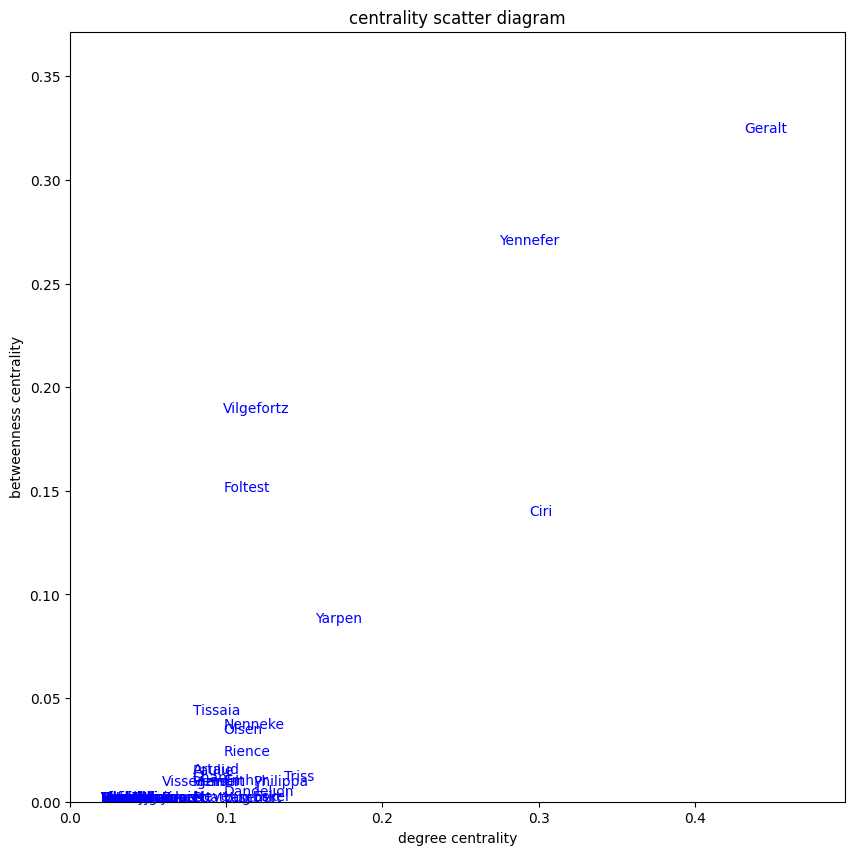

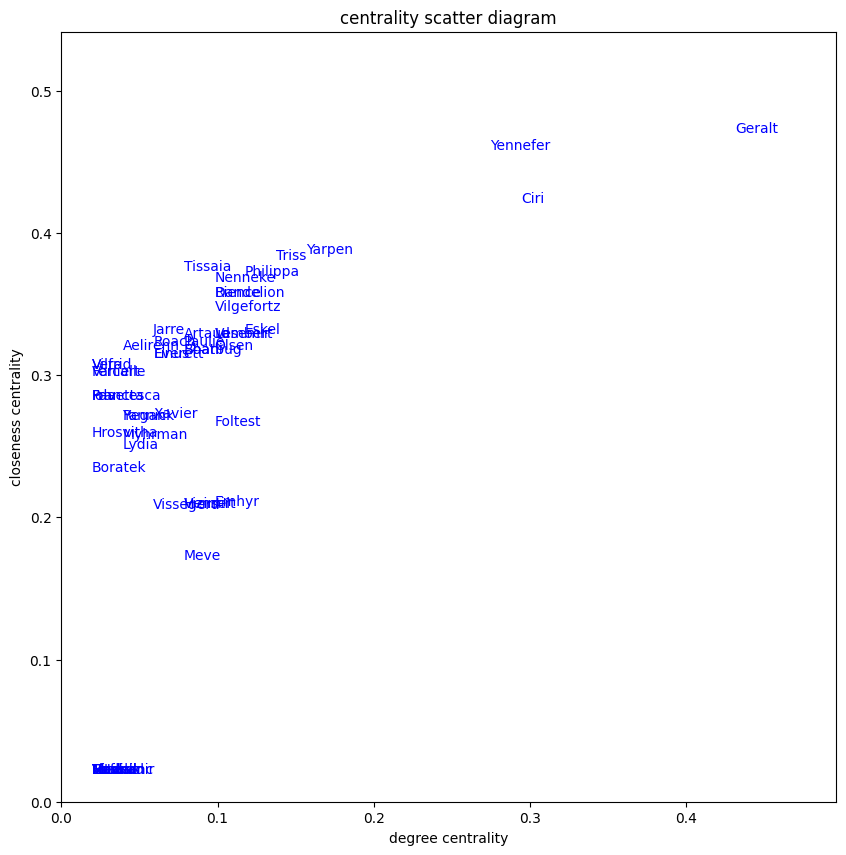

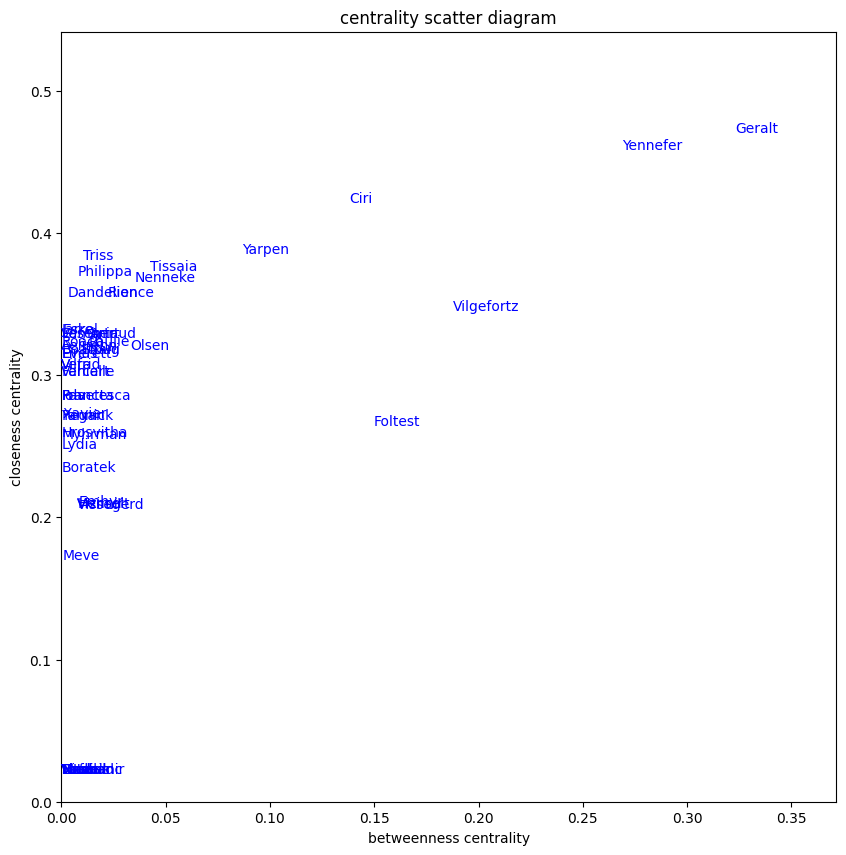

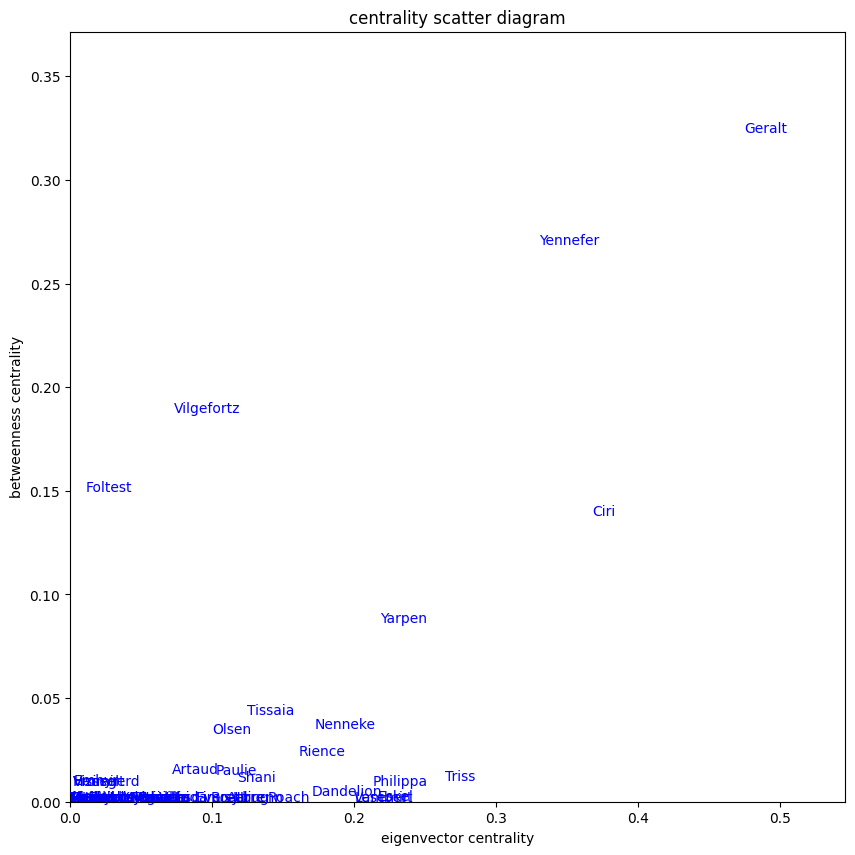

In [39]:
##########################
# Draw centrality scatter 
centrality_scatter(dc,bc,path="cum18bcdc",ylab="betweenness centrality",xlab="degree centrality",title="centrality scatter diagram",line=False)
centrality_scatter(dc,cc,path="cum18ccdc",ylab="closeness centrality",xlab="degree centrality",title="centrality scatter diagram",line=False)
centrality_scatter(bc,cc,path="cum18ccbc",ylab="closeness centrality",xlab="betweenness centrality",title="centrality scatter diagram",line=False)
centrality_scatter(ec,bc,path="cum18bcec",ylab="betweenness centrality",xlab="eigenvector centrality",title="centrality scatter diagram",line=False)




In [40]:
#import seaborn as sns
centrality_measures = {
    'degree': degc,
    'betweenness': bet,
    'closeness': clos,
    'PageRank': pgr,
}
centrality = pd.DataFrame(centrality_measures)
centrality.sort_values(by=['degree','betweenness','closeness','PageRank'],ascending=False).head(20)

degree  betweenness  closeness  PageRank
Geralt      0.431373     0.323046   0.470843  0.086619
Ciri        0.294118     0.138157   0.421569  0.061664
Yennefer    0.274510     0.268706   0.458923  0.056730
Yarpen      0.156863     0.086484   0.385690  0.033466
Triss       0.137255     0.010392   0.381631  0.026695
Philippa    0.117647     0.007922   0.369948  0.023838
Eskel       0.117647     0.000784   0.329590  0.023323
Vilgefortz  0.098039     0.187843   0.345285  0.022186
Foltest     0.098039     0.149542   0.264634  0.022450
Nenneke     0.098039     0.035320   0.366211  0.022797
Olsen       0.098039     0.033203   0.318025  0.024167
Rience      0.098039     0.022431   0.355440  0.020794
Emhyr       0.098039     0.008170   0.208362  0.022619
Dandelion   0.098039     0.002876   0.355440  0.020274
Vesemir     0.098039     0.000000   0.326621  0.019603
Lambert     0.098039     0.000000   0.326621  0.019603
Tissaia     0.078431     0.042353   0.373762  0.017328
Artaud      0.078431     0.013725   0.326621  0.018261
Paulie      0.078431     0.013046   0.320840  0.018403
Shani       0.078431     0.009725   0.315260  0.017350

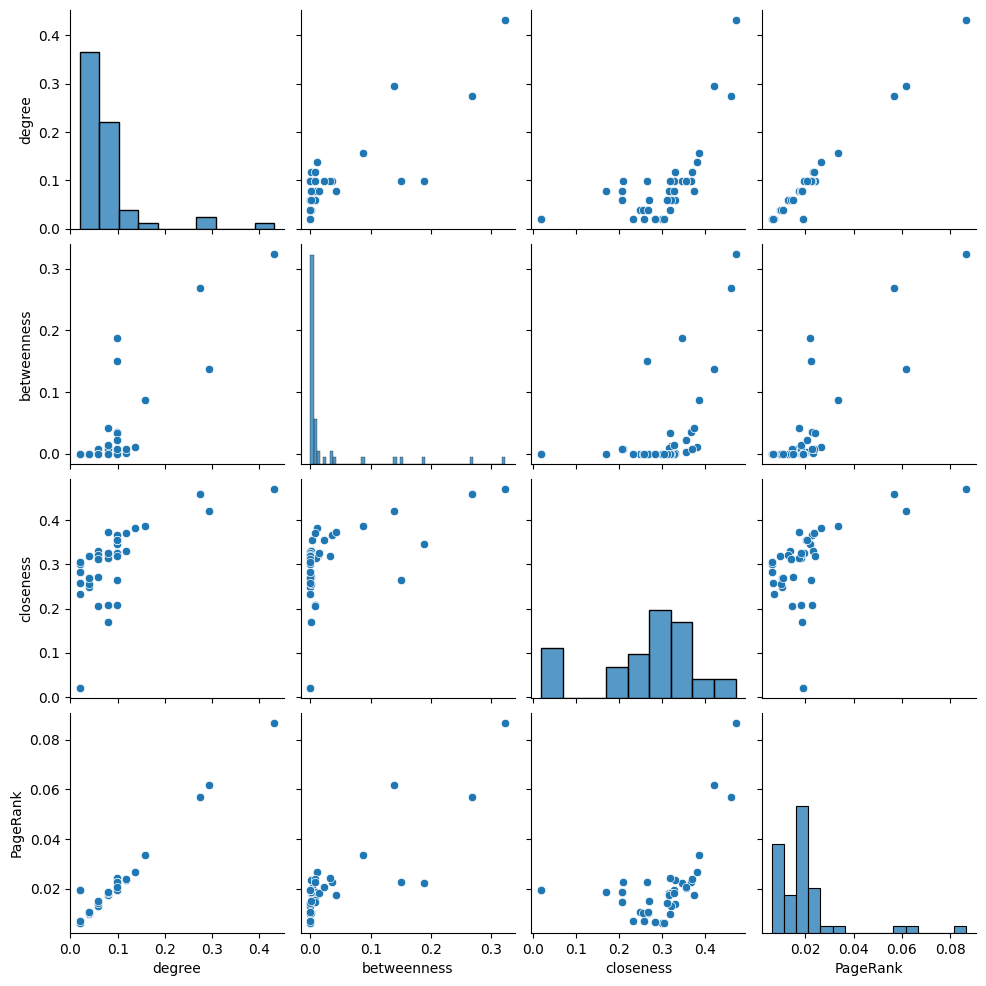

In [41]:
import seaborn as sns
sns.pairplot(centrality)

# Section 2.a


#### If four centrality measures are not highly correlated with each other, it may suggest that they capture different aspects of network structure or importance.


#### If these centrality measures are not highly correlated, it may indicate that different nodes are important for different reasons. For example, a node may have a high degree centrality because it is highly connected to other nodes, but may not have high betweenness centrality if it is not located on many shortest paths. Similarly, a node may have high eigenvector centrality because it is connected to other highly central nodes, but may not have high closeness centrality if it is not located close to many other nodes.


#### Therefore, the lack of high correlation between centrality measures may suggest that each measure is capturing a unique aspect of node importance in the network. It may also indicate that a combination of centrality measures should be used to fully understand the importance of nodes in the network.

#### But in our case, as we observe the graph, all 4 centralites seem to be resonably correlated enough to conclude that any one centrality measure( take degree for example) is good enough to find the protagonists


#### And in fact that is the case, Geralt has the most Centralitiy values of all the 4 measures with Ciri following him in second


#### Yennefer and Yarpen can be considered as minor protagonist characters or the best supporting characters with Triss being an interesting wildcard supporting character.

#### This aligns with most people's understanding of the story but Triss being so high is an interesting insight that our analysis has revealed that is outside the norm of understanding of the novel

# Section 1.d
### Clustering Coefficient:

In [42]:
print(nx.transitivity(G))

0.3598200899550225


In [43]:
print("Global Clustering Coefficient :  "+str(nx.average_clustering(G)))

Global Clustering Coefficient :  0.4593579497425652


In [44]:
#local clustering coefficient for protagonists:
c=nx.clustering(G)
select_list=['Ciri','Geralt','Yennefer','Yarpen']
res = [c[i] for i in select_list if i in c]
print("Ciri : " + str(res[0]))
print("Geralt : " + str(res[1]))
print("Yennefer : " + str(res[2]))
print("Yarpen : " + str(res[3]))

Ciri : 0.22857142857142856
Geralt : 0.15584415584415584
Yennefer : 0.23076923076923078
Yarpen : 0.35714285714285715


In [45]:
#local clustering coefficient of each of characters:c
c

{'Ciri': 0.22857142857142856,
 'Yennefer': 0.23076923076923078,
 'Geralt': 0.15584415584415584,
 'Triss': 0.7142857142857143,
 'Yarpen': 0.35714285714285715,
 'Vesemir': 1.0,
 'Jarre': 1.0,
 'Nenneke': 0.5,
 'Lydia': 1.0,
 'Vilgefortz': 0.4,
 'Dandelion': 0.8,
 'Eskel': 0.8,
 'Boatbug': 0.8333333333333334,
 'Lambert': 1.0,
 'Paulie': 0.5,
 'Regan': 1.0,
 'Tissaia': 0.6666666666666666,
 'Philippa': 0.6666666666666666,
 'Olsen': 0.5,
 'Everett': 1.0,
 'Shani': 0.5,
 'Roach': 1.0,
 'Henselt': 0.8333333333333334,
 'Vizimir': 0.8333333333333334,
 'Emhyr': 0.7,
 'Foltest': 0.4,
 'Artaud': 0.6666666666666666,
 'Vissegerd': 0.6666666666666666,
 'Fercart': 0,
 'Meve': 0.6666666666666666,
 'Rience': 0.6,
 'Aelirenn': 1.0,
 'Pavetta': 0,
 'Vilfrid': 0,
 'Linus': 1.0,
 'Iola': 0,
 'Stran': 0,
 'Vitek': 0,
 'Esterad': 0,
 'Niedamir': 0,
 'Medell': 0,
 'Virfuril': 0,
 'Xavier': 0.6666666666666666,
 'Myhrman': 0,
 'Boratek': 0,
 'Vanielle': 0,
 'Yannick': 1.0,
 'Francesca': 0,
 'Vera': 0,
 'Hrosvitha

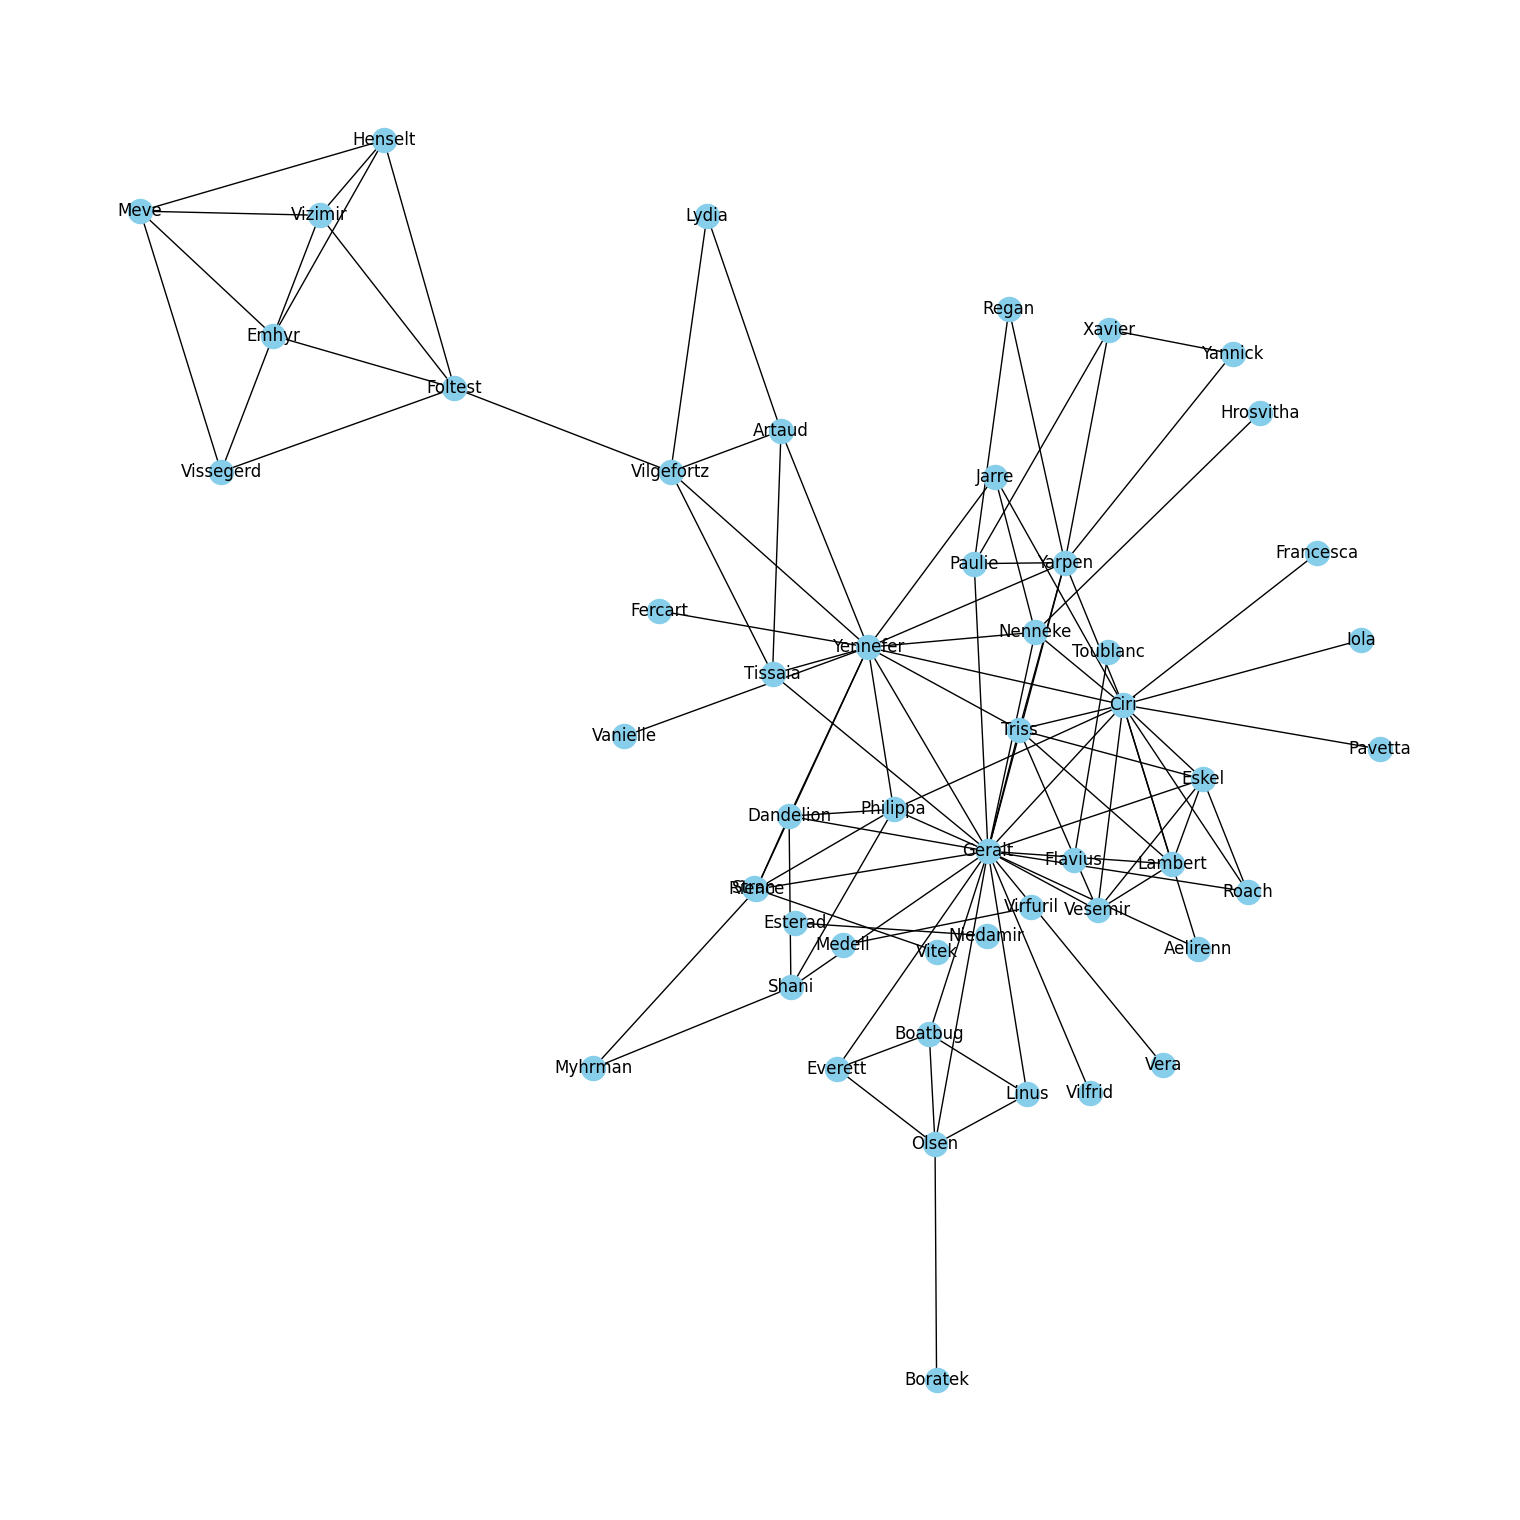

In [46]:
plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [47]:
s='\n Transitivity  analysis: '
print (s)

# which are the nodes that are contributing in the transitivity ?
t=nx.triangles(G)
s='\n No of triads that include node as a vertex : ' +repr(t)
print (s)



 Transitivity  analysis: 

 No of triads that include node as a vertex : {'Ciri': 24, 'Yennefer': 21, 'Geralt': 36, 'Triss': 15, 'Yarpen': 10, 'Vesemir': 10, 'Jarre': 3, 'Nenneke': 5, 'Lydia': 1, 'Vilgefortz': 4, 'Dandelion': 8, 'Eskel': 12, 'Boatbug': 5, 'Lambert': 10, 'Paulie': 3, 'Regan': 1, 'Tissaia': 4, 'Philippa': 10, 'Olsen': 5, 'Everett': 3, 'Shani': 3, 'Roach': 3, 'Henselt': 5, 'Vizimir': 5, 'Emhyr': 7, 'Foltest': 4, 'Artaud': 4, 'Vissegerd': 2, 'Fercart': 0, 'Meve': 4, 'Rience': 6, 'Aelirenn': 1, 'Pavetta': 0, 'Vilfrid': 0, 'Linus': 3, 'Iola': 0, 'Stran': 0, 'Vitek': 0, 'Esterad': 0, 'Niedamir': 0, 'Medell': 0, 'Virfuril': 0, 'Xavier': 2, 'Myhrman': 0, 'Boratek': 0, 'Vanielle': 0, 'Yannick': 1, 'Francesca': 0, 'Vera': 0, 'Hrosvitha': 0, 'Flavius': 0, 'Toublanc': 0}


# Section 1.e

#### Community detection

# Louvain:

In [48]:
%pip install python-louvain

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\shubh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [49]:
import community as community_louvain

In [50]:
communities = community_louvain.best_partition(G)

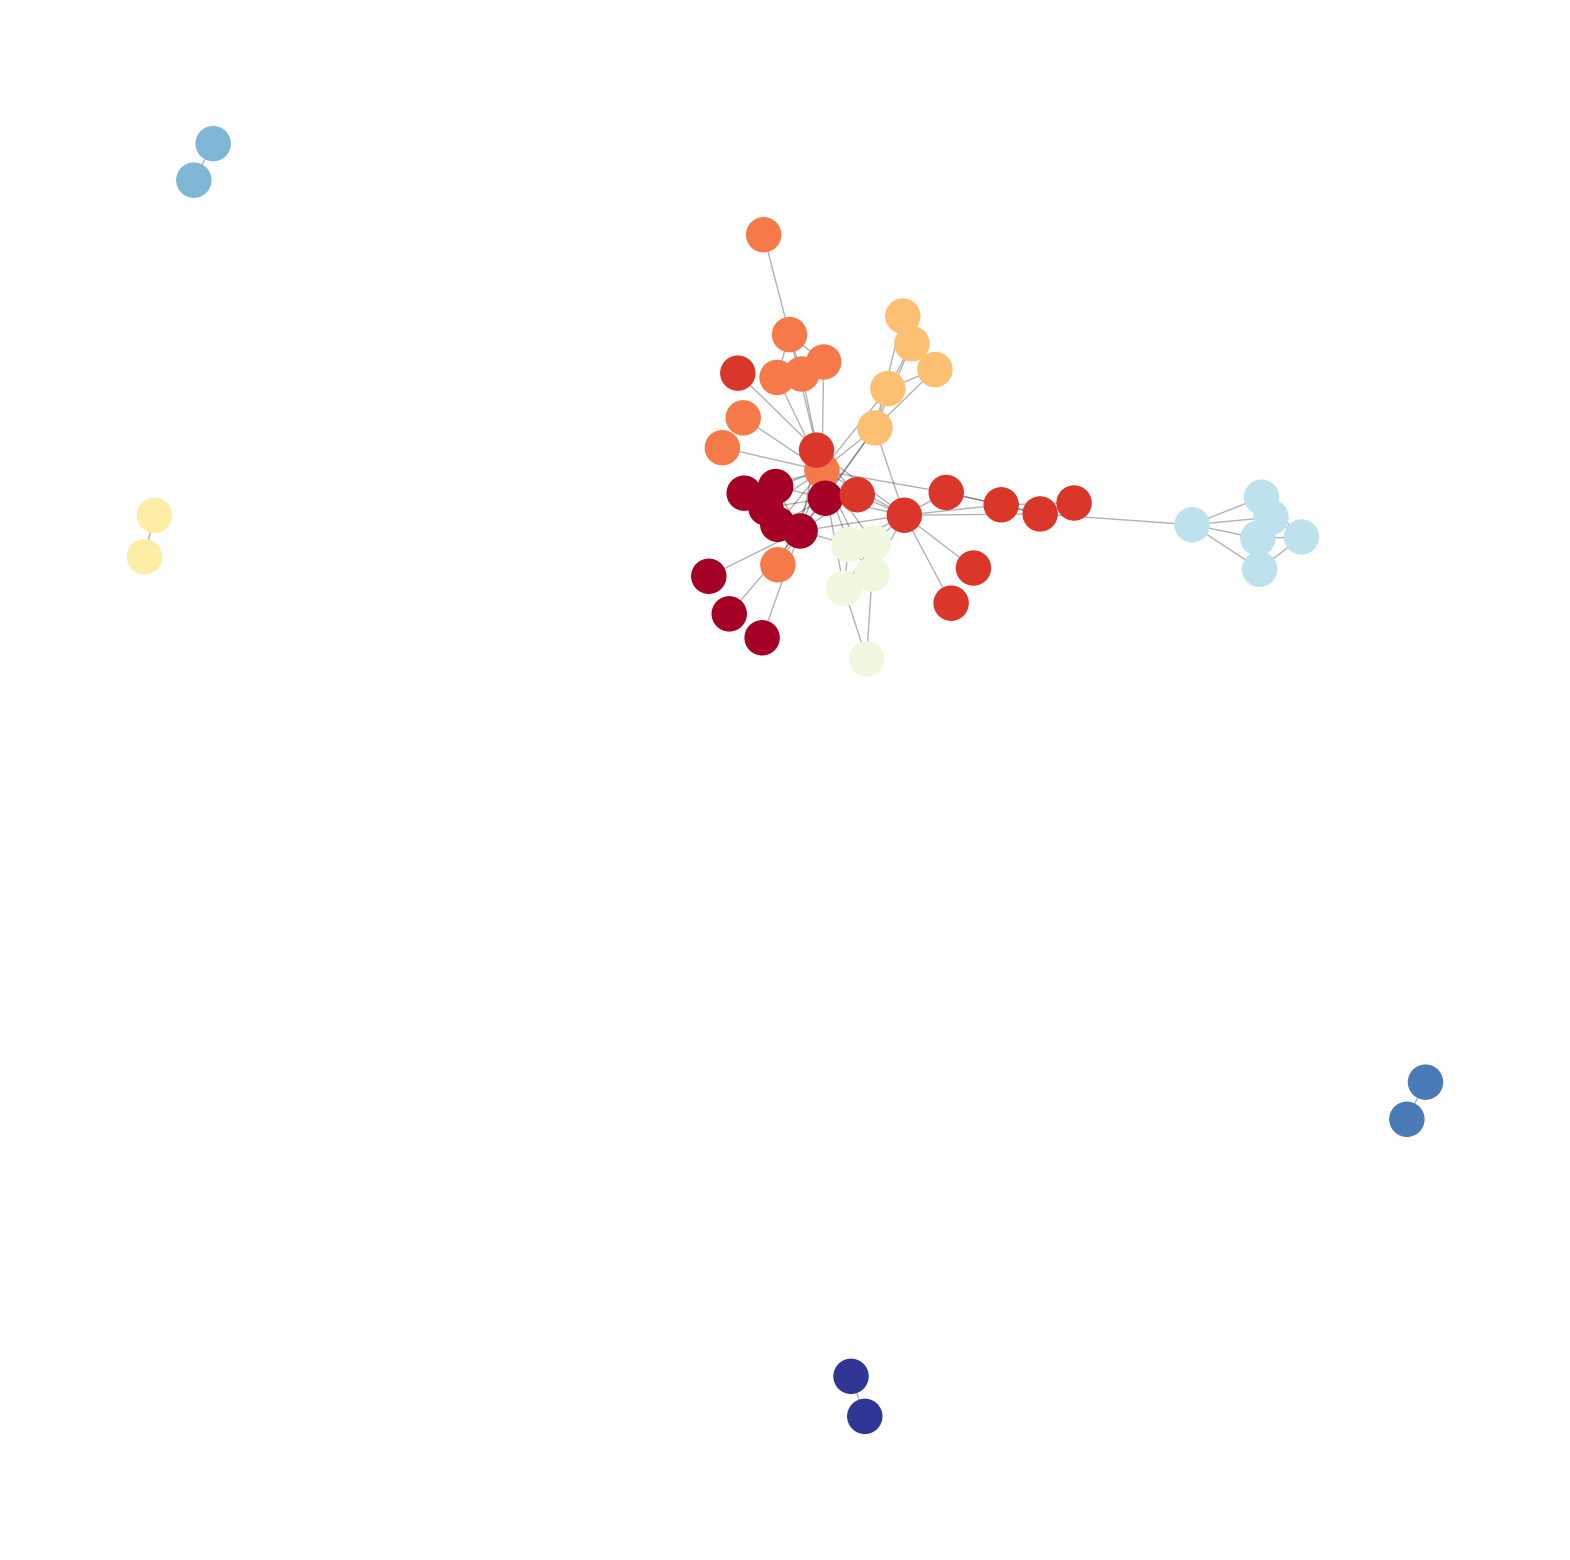

In [51]:
#plot partitioned community
pos = nx.spring_layout(G)
plt.figure(figsize=(20, 20))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=list(communities.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show(G)

In [52]:
communities

{'Ciri': 0,
 'Yennefer': 1,
 'Geralt': 2,
 'Triss': 0,
 'Yarpen': 3,
 'Vesemir': 0,
 'Jarre': 1,
 'Nenneke': 1,
 'Lydia': 1,
 'Vilgefortz': 1,
 'Dandelion': 5,
 'Eskel': 0,
 'Boatbug': 2,
 'Lambert': 0,
 'Paulie': 3,
 'Regan': 3,
 'Tissaia': 1,
 'Philippa': 5,
 'Olsen': 2,
 'Everett': 2,
 'Shani': 5,
 'Roach': 0,
 'Henselt': 6,
 'Vizimir': 6,
 'Emhyr': 6,
 'Foltest': 6,
 'Artaud': 1,
 'Vissegerd': 6,
 'Fercart': 1,
 'Meve': 6,
 'Rience': 5,
 'Aelirenn': 2,
 'Pavetta': 0,
 'Vilfrid': 2,
 'Linus': 2,
 'Iola': 0,
 'Stran': 7,
 'Vitek': 7,
 'Esterad': 8,
 'Niedamir': 8,
 'Medell': 9,
 'Virfuril': 9,
 'Xavier': 3,
 'Myhrman': 5,
 'Boratek': 2,
 'Vanielle': 1,
 'Yannick': 3,
 'Francesca': 0,
 'Vera': 2,
 'Hrosvitha': 1,
 'Flavius': 4,
 'Toublanc': 4}

In [53]:
nx.set_node_attributes(G, communities, 'group')

In [54]:
# com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
# com_net.from_nx(G)
# com_net.show("witcher_communities.html")

# K-Clique Percolation:

In [55]:
list(nx.find_cliques(G))  # Search for all maximal cliques in a graph.

[['Medell', 'Virfuril'],
 ['Pavetta', 'Ciri'],
 ['Niedamir', 'Esterad'],
 ['Vitek', 'Stran'],
 ['Vanielle', 'Yennefer'],
 ['Emhyr', 'Vissegerd', 'Foltest'],
 ['Emhyr', 'Vissegerd', 'Meve'],
 ['Emhyr', 'Henselt', 'Vizimir', 'Foltest'],
 ['Emhyr', 'Henselt', 'Vizimir', 'Meve'],
 ['Lydia', 'Vilgefortz', 'Artaud'],
 ['Yannick', 'Xavier', 'Yarpen'],
 ['Francesca', 'Ciri'],
 ['Boratek', 'Olsen'],
 ['Geralt', 'Boatbug', 'Olsen', 'Linus'],
 ['Geralt', 'Boatbug', 'Olsen', 'Everett'],
 ['Geralt', 'Tissaia', 'Yennefer'],
 ['Geralt', 'Shani', 'Philippa', 'Dandelion'],
 ['Geralt', 'Ciri', 'Philippa', 'Yennefer'],
 ['Geralt', 'Ciri', 'Nenneke', 'Yennefer'],
 ['Geralt', 'Ciri', 'Triss', 'Yarpen', 'Yennefer'],
 ['Geralt', 'Ciri', 'Triss', 'Lambert', 'Eskel', 'Vesemir'],
 ['Geralt', 'Ciri', 'Roach', 'Eskel'],
 ['Geralt', 'Ciri', 'Aelirenn'],
 ['Geralt', 'Vera'],
 ['Geralt', 'Vilfrid'],
 ['Geralt', 'Rience', 'Philippa', 'Yennefer', 'Dandelion'],
 ['Geralt', 'Paulie', 'Yarpen'],
 ['Myhrman', 'Rience'],
 

In [56]:
from networkx.algorithms.community import k_clique_communities  # find k-clique community using percolation method
c = list(k_clique_communities(G, 4))
c

[frozenset({'Emhyr', 'Foltest', 'Henselt', 'Meve', 'Vizimir'}),
 frozenset({'Boatbug', 'Everett', 'Geralt', 'Linus', 'Olsen'}),
 frozenset({'Ciri',
            'Dandelion',
            'Eskel',
            'Geralt',
            'Jarre',
            'Lambert',
            'Nenneke',
            'Philippa',
            'Rience',
            'Roach',
            'Shani',
            'Triss',
            'Vesemir',
            'Yarpen',
            'Yennefer'}),
 frozenset({'Artaud', 'Tissaia', 'Vilgefortz', 'Yennefer'})]

In [57]:
#list out identified community nodes
print(list(c[0]))
print(list(c[1]))
print(list(c[2]))
print(list(c[3]))

['Henselt', 'Foltest', 'Emhyr', 'Vizimir', 'Meve']
['Boatbug', 'Olsen', 'Linus', 'Everett', 'Geralt']
['Philippa', 'Nenneke', 'Rience', 'Roach', 'Lambert', 'Jarre', 'Shani', 'Vesemir', 'Ciri', 'Triss', 'Yarpen', 'Eskel', 'Yennefer', 'Dandelion', 'Geralt']
['Vilgefortz', 'Artaud', 'Tissaia', 'Yennefer']


# Girvan Newman community detection:

In [58]:
from networkx.algorithms.community.centrality import girvan_newman
communities_generator = girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))

[['Aelirenn',
  'Artaud',
  'Ciri',
  'Dandelion',
  'Eskel',
  'Fercart',
  'Francesca',
  'Geralt',
  'Hrosvitha',
  'Iola',
  'Jarre',
  'Lambert',
  'Lydia',
  'Myhrman',
  'Nenneke',
  'Paulie',
  'Pavetta',
  'Philippa',
  'Regan',
  'Rience',
  'Roach',
  'Shani',
  'Tissaia',
  'Triss',
  'Vanielle',
  'Vera',
  'Vesemir',
  'Vilfrid',
  'Vilgefortz',
  'Xavier',
  'Yannick',
  'Yarpen',
  'Yennefer'],
 ['Boatbug', 'Boratek', 'Everett', 'Linus', 'Olsen'],
 ['Emhyr', 'Foltest', 'Henselt', 'Meve', 'Vissegerd', 'Vizimir'],
 ['Esterad', 'Niedamir'],
 ['Flavius', 'Toublanc'],
 ['Medell', 'Virfuril'],
 ['Stran', 'Vitek']]

In [59]:
#first compute the best partition
import community
part = community.best_partition(G)
part

{'Ciri': 0,
 'Yennefer': 4,
 'Geralt': 2,
 'Triss': 0,
 'Yarpen': 3,
 'Vesemir': 0,
 'Jarre': 4,
 'Nenneke': 4,
 'Lydia': 5,
 'Vilgefortz': 5,
 'Dandelion': 4,
 'Eskel': 0,
 'Boatbug': 2,
 'Lambert': 0,
 'Paulie': 3,
 'Regan': 3,
 'Tissaia': 5,
 'Philippa': 4,
 'Olsen': 2,
 'Everett': 2,
 'Shani': 4,
 'Roach': 0,
 'Henselt': 7,
 'Vizimir': 7,
 'Emhyr': 7,
 'Foltest': 7,
 'Artaud': 5,
 'Vissegerd': 7,
 'Fercart': 4,
 'Meve': 7,
 'Rience': 4,
 'Aelirenn': 2,
 'Pavetta': 0,
 'Vilfrid': 2,
 'Linus': 2,
 'Iola': 0,
 'Stran': 8,
 'Vitek': 8,
 'Esterad': 9,
 'Niedamir': 9,
 'Medell': 1,
 'Virfuril': 1,
 'Xavier': 3,
 'Myhrman': 4,
 'Boratek': 2,
 'Vanielle': 4,
 'Yannick': 3,
 'Francesca': 0,
 'Vera': 2,
 'Hrosvitha': 4,
 'Flavius': 6,
 'Toublanc': 6}

In [60]:
print(community.modularity(part, G))  #modularity of hypothesised detected communities

0.5416000000000001


In [61]:
induced = community.induced_graph(part, G)
print(induced.nodes())
print(induced.edges())

[0, 4, 2, 3, 5, 7, 8, 9, 1, 6]
[(0, 4), (0, 2), (0, 0), (0, 3), (4, 2), (4, 4), (4, 5), (4, 3), (2, 3), (2, 2), (2, 5), (3, 3), (5, 5), (5, 7), (7, 7), (8, 8), (9, 9), (1, 1), (6, 6)]


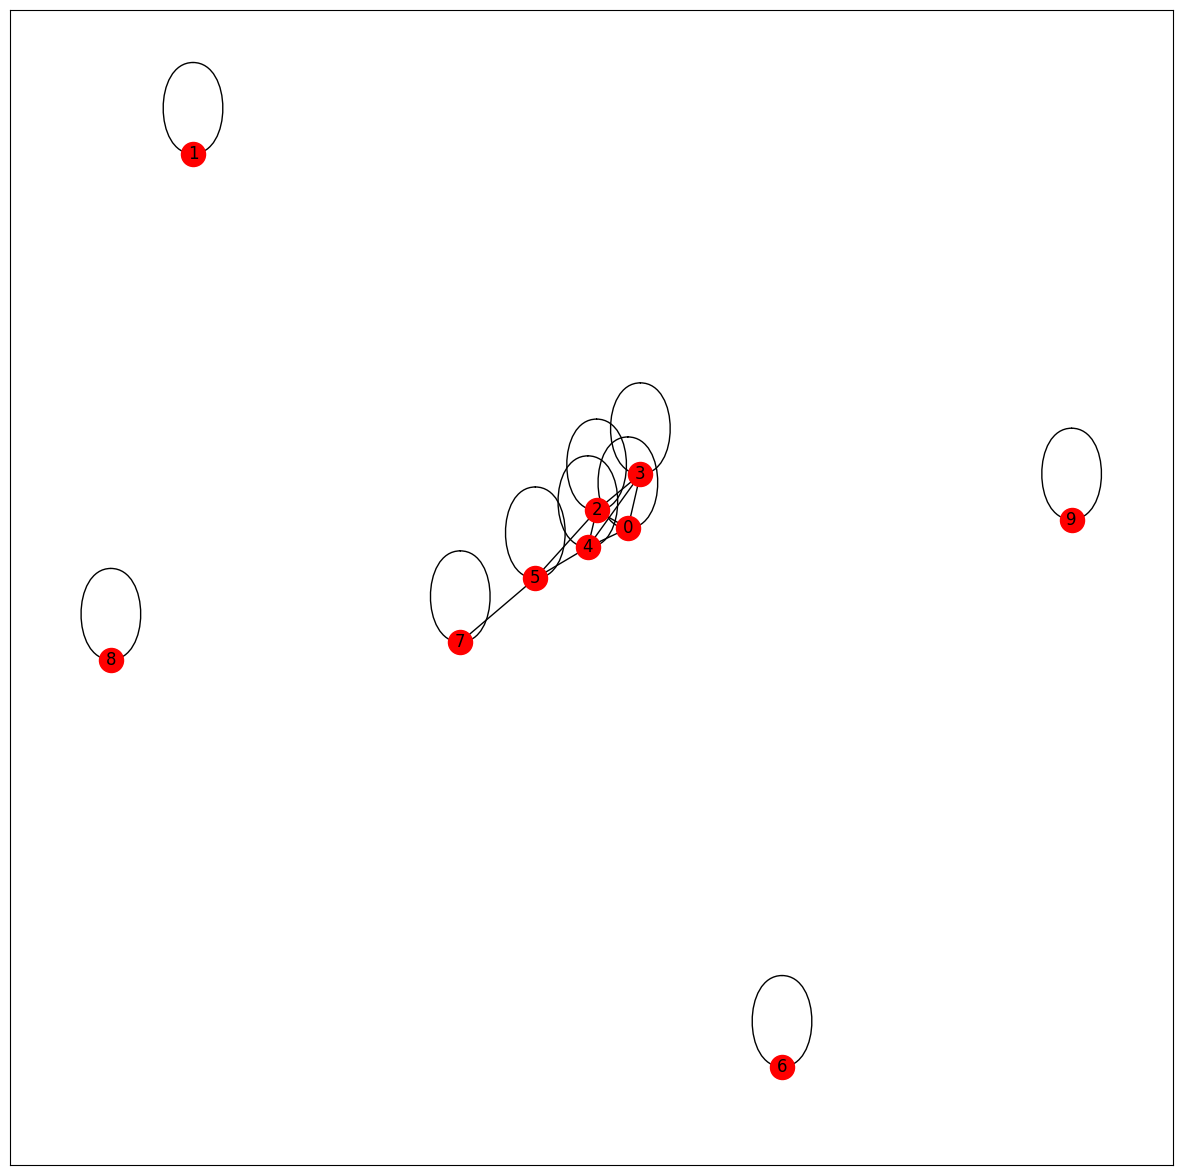

In [62]:
plt.figure(figsize=(15,15))
nx.draw_networkx(induced,node_color='red')

# Section 1.f

#### Degree Distribution

In [63]:
N,K = G.order(), G.size()
avg_deg = float(K)/N
print ("Nodes: ", N)
print ("Edges: ", K)
print ("Average degree: ", avg_deg)


Nodes:  52
Edges:  100
Average degree:  1.9230769230769231


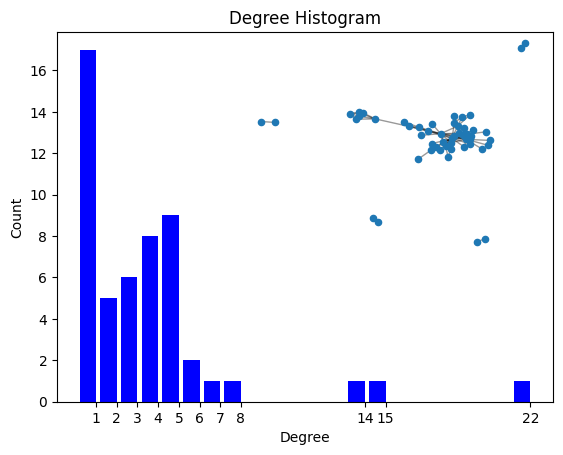

In [64]:
import collections

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
A = (G.subgraph(c) for c in nx.connected_components(G))
# = list(A)[0]
Gcc = sorted(A, key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()

(0.9, 10001)

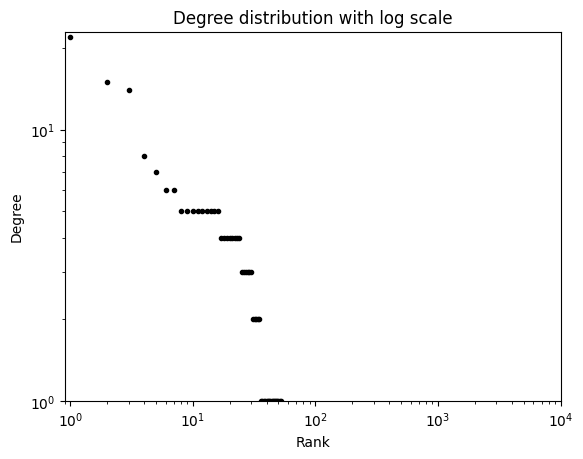

In [65]:
degrees = G.degree()
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence

# loglog tells matplotlib to use log scales.
# The x values, range(1,10001), are the ranks, 
# and the degree_sequence are the y values.
# The String 'k.' means use black (k) dots (.)

plt.loglog(range(1,G.order()+1),degree_sequence,'k.')
plt.title("Degree distribution with log scale")
plt.xlabel('Rank')
plt.ylabel('Degree')
plt.ylim(1,max(degree_sequence)+1)
plt.xlim(.9,10001)

# Ego network of protagonists:


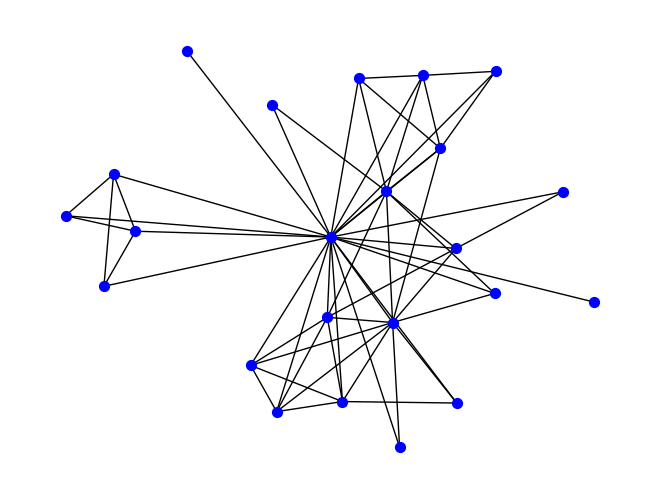

Geralt's Ego Network : nodes 23
Geralt's Ego Network : edges 58


In [66]:
s='Geralt'
hub_ego=nx.ego_graph(G,s)
# Draw graph
pos=nx.spring_layout(hub_ego)
nx.draw(hub_ego,pos,node_color='b',node_size=50,with_labels=False)
plt.show()
no_node=len(hub_ego.nodes())
no_edges=len(hub_ego.edges())
print("Geralt's Ego Network : nodes", no_node)
print("Geralt's Ego Network : edges", no_edges)


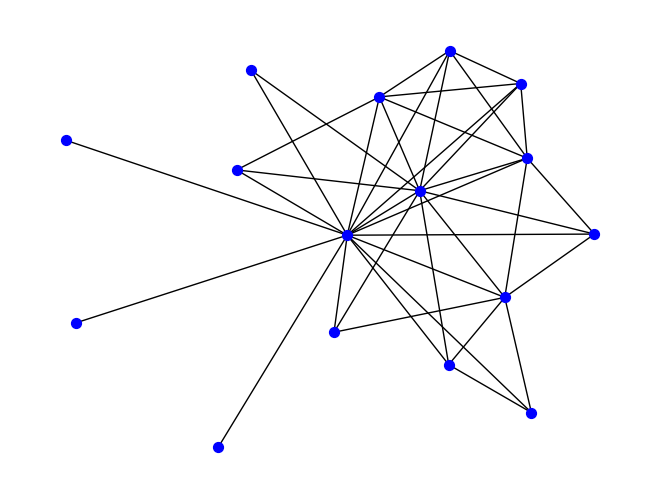

Ciri's Ego Network : nodes 16
Ciri's Ego Network : edges 39


In [67]:
s='Ciri'
hub_ego=nx.ego_graph(G,s)
# Draw graph
pos=nx.spring_layout(hub_ego)
nx.draw(hub_ego,pos,node_color='b',node_size=50,with_labels=False)
plt.show()
no_node=len(hub_ego.nodes())
no_edges=len(hub_ego.edges())
print("Ciri's Ego Network : nodes", no_node)
print("Ciri's Ego Network : edges", no_edges)


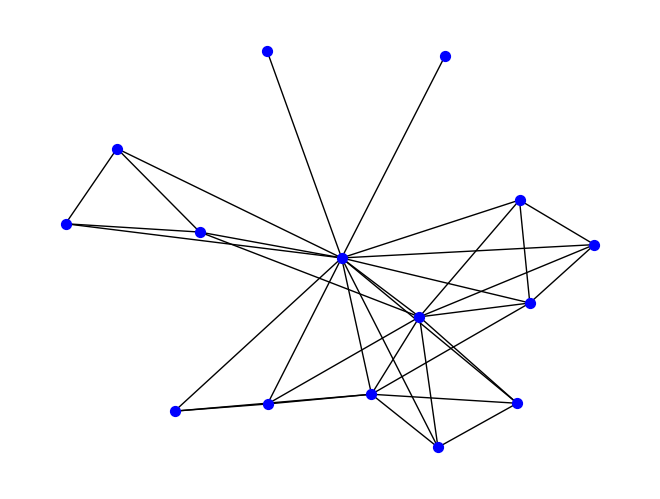

Yennefer's Ego Network : nodes 15
Yennefer's Ego Network : edges 35


In [68]:
s='Yennefer'
hub_ego=nx.ego_graph(G,s)
# Draw graph
pos=nx.spring_layout(hub_ego)
nx.draw(hub_ego,pos,node_color='b',node_size=50,with_labels=False)
plt.show()
no_node=len(hub_ego.nodes())
no_edges=len(hub_ego.edges())
print("Yennefer's Ego Network : nodes", no_node)
print("Yennefer's Ego Network : edges", no_edges)


# Average Shortest paths:

In [69]:
#Position nodes using Fruchterman-Reingold force-directed algorithm.
pos_spring = nx.spring_layout(G)
pos_fr = nx.fruchterman_reingold_layout(G)
pos_fr

{'Ciri': array([-0.06065838,  0.18448898]),
 'Yennefer': array([-0.06785405,  0.03003074]),
 'Geralt': array([0.00261044, 0.09694849]),
 'Triss': array([-0.05681108,  0.1363357 ]),
 'Yarpen': array([-0.13605007,  0.1652151 ]),
 'Vesemir': array([-0.01392577,  0.15750456]),
 'Jarre': array([-0.14338308,  0.11378554]),
 'Nenneke': array([-0.13168206,  0.09013924]),
 'Lydia': array([ 0.05335025, -0.17425494]),
 'Vilgefortz': array([ 0.11076687, -0.07728831]),
 'Dandelion': array([-0.03931362,  0.00991345]),
 'Eskel': array([0.0105881 , 0.17640595]),
 'Boatbug': array([0.11919828, 0.07889255]),
 'Lambert': array([-0.02238815,  0.19335421]),
 'Paulie': array([-0.1314836,  0.2056055]),
 'Regan': array([-0.18896482,  0.26434262]),
 'Tissaia': array([ 0.02200012, -0.02678711]),
 'Philippa': array([-0.05126563,  0.05837464]),
 'Olsen': array([0.14713465, 0.02800839]),
 'Everett': array([0.10301578, 0.04759184]),
 'Shani': array([-0.03915052, -0.03190299]),
 'Roach': array([0.04205973, 0.2008969

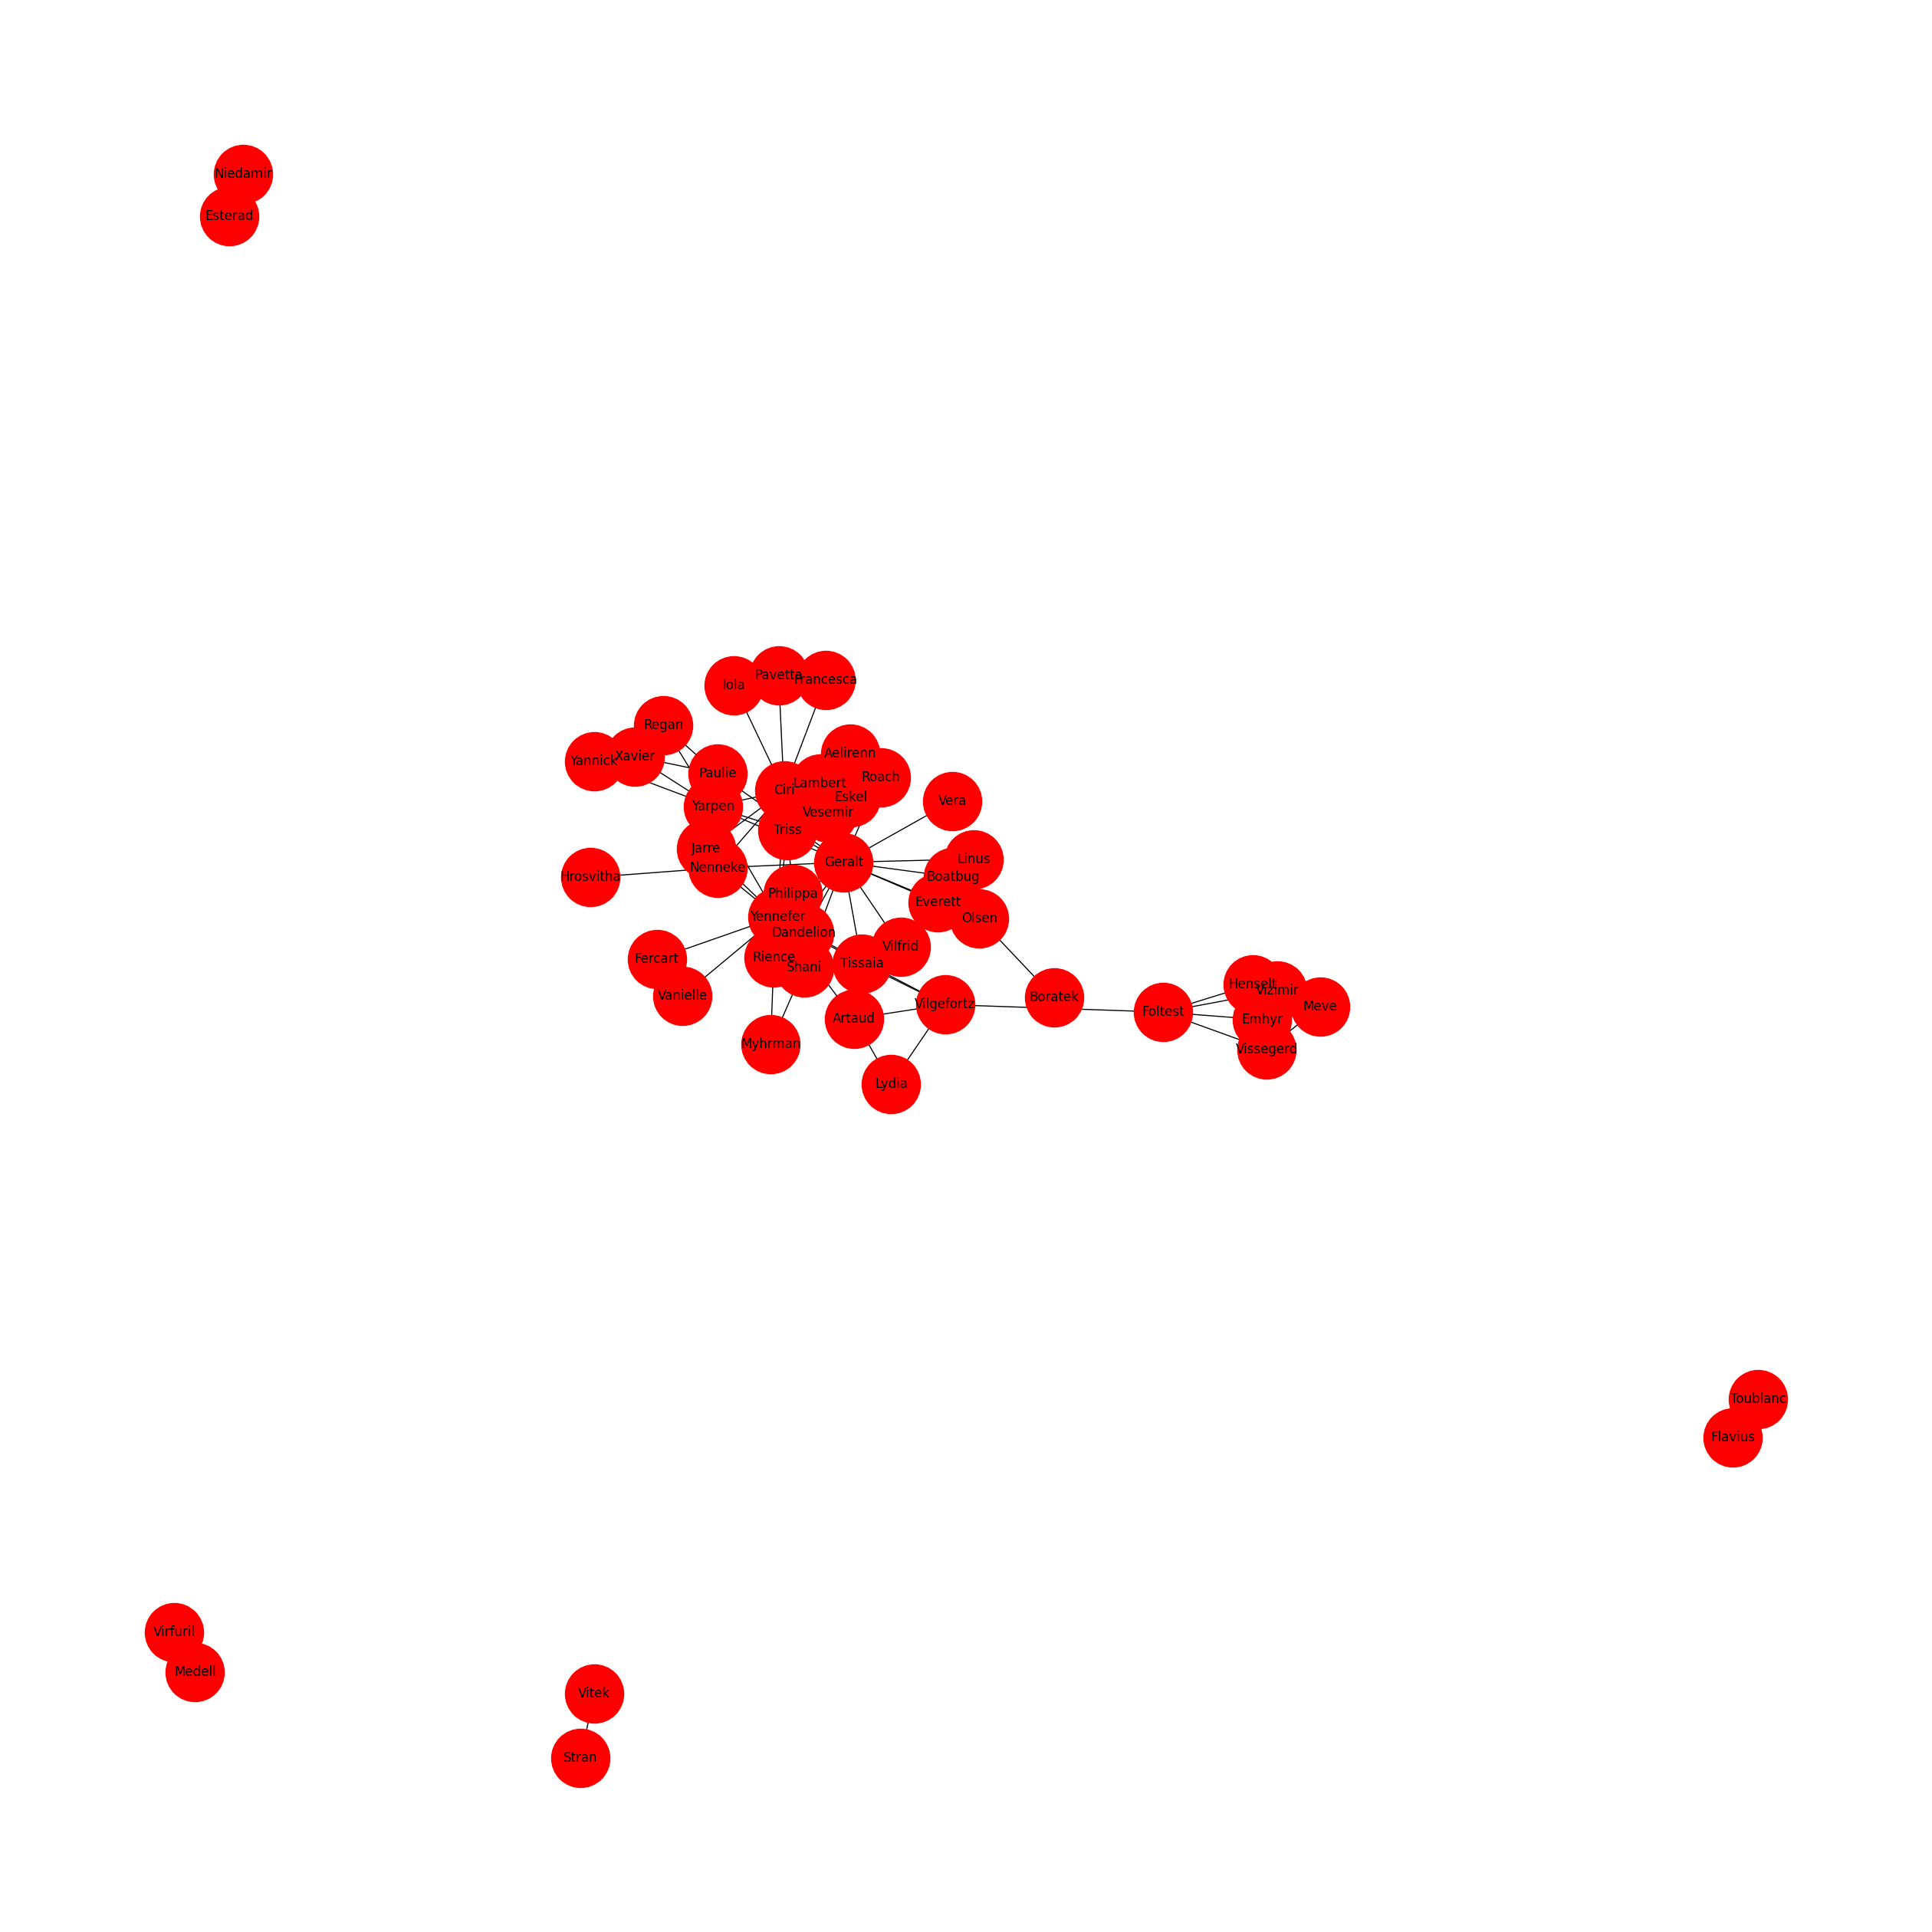

In [70]:
plt.figure(figsize=(25,25))
nx.draw(G, pos=pos_fr, node_size=3000, node_color='red', with_labels=True)

In [71]:
source = 'Geralt'
target = 'Vizimir'
nx.shortest_path(G, source, target)
list(nx.all_shortest_paths(G, source, target))#shortest paths may/not be unique

[['Geralt', 'Yennefer', 'Vilgefortz', 'Foltest', 'Vizimir'],
 ['Geralt', 'Tissaia', 'Vilgefortz', 'Foltest', 'Vizimir']]

In [72]:
def plot_paths(G, paths):
    plt.figure(figsize=(32,32))
    pos = nx.fruchterman_reingold_layout(G)
    nx.draw_networkx_nodes(G, pos=pos, node_size=3000, node_color='yellow')
    nx.draw_networkx_labels(G, pos=pos, labels={n: n for n in G})
    # Draw edges
    nx.draw_networkx_edges(G, pos=pos)
    for path in paths:
        edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(G, pos=pos, edgelist=edges, edge_color='red', width=3)
    ax = plt.gca()
    ax.set_axis_off()
    ax.grid(None)

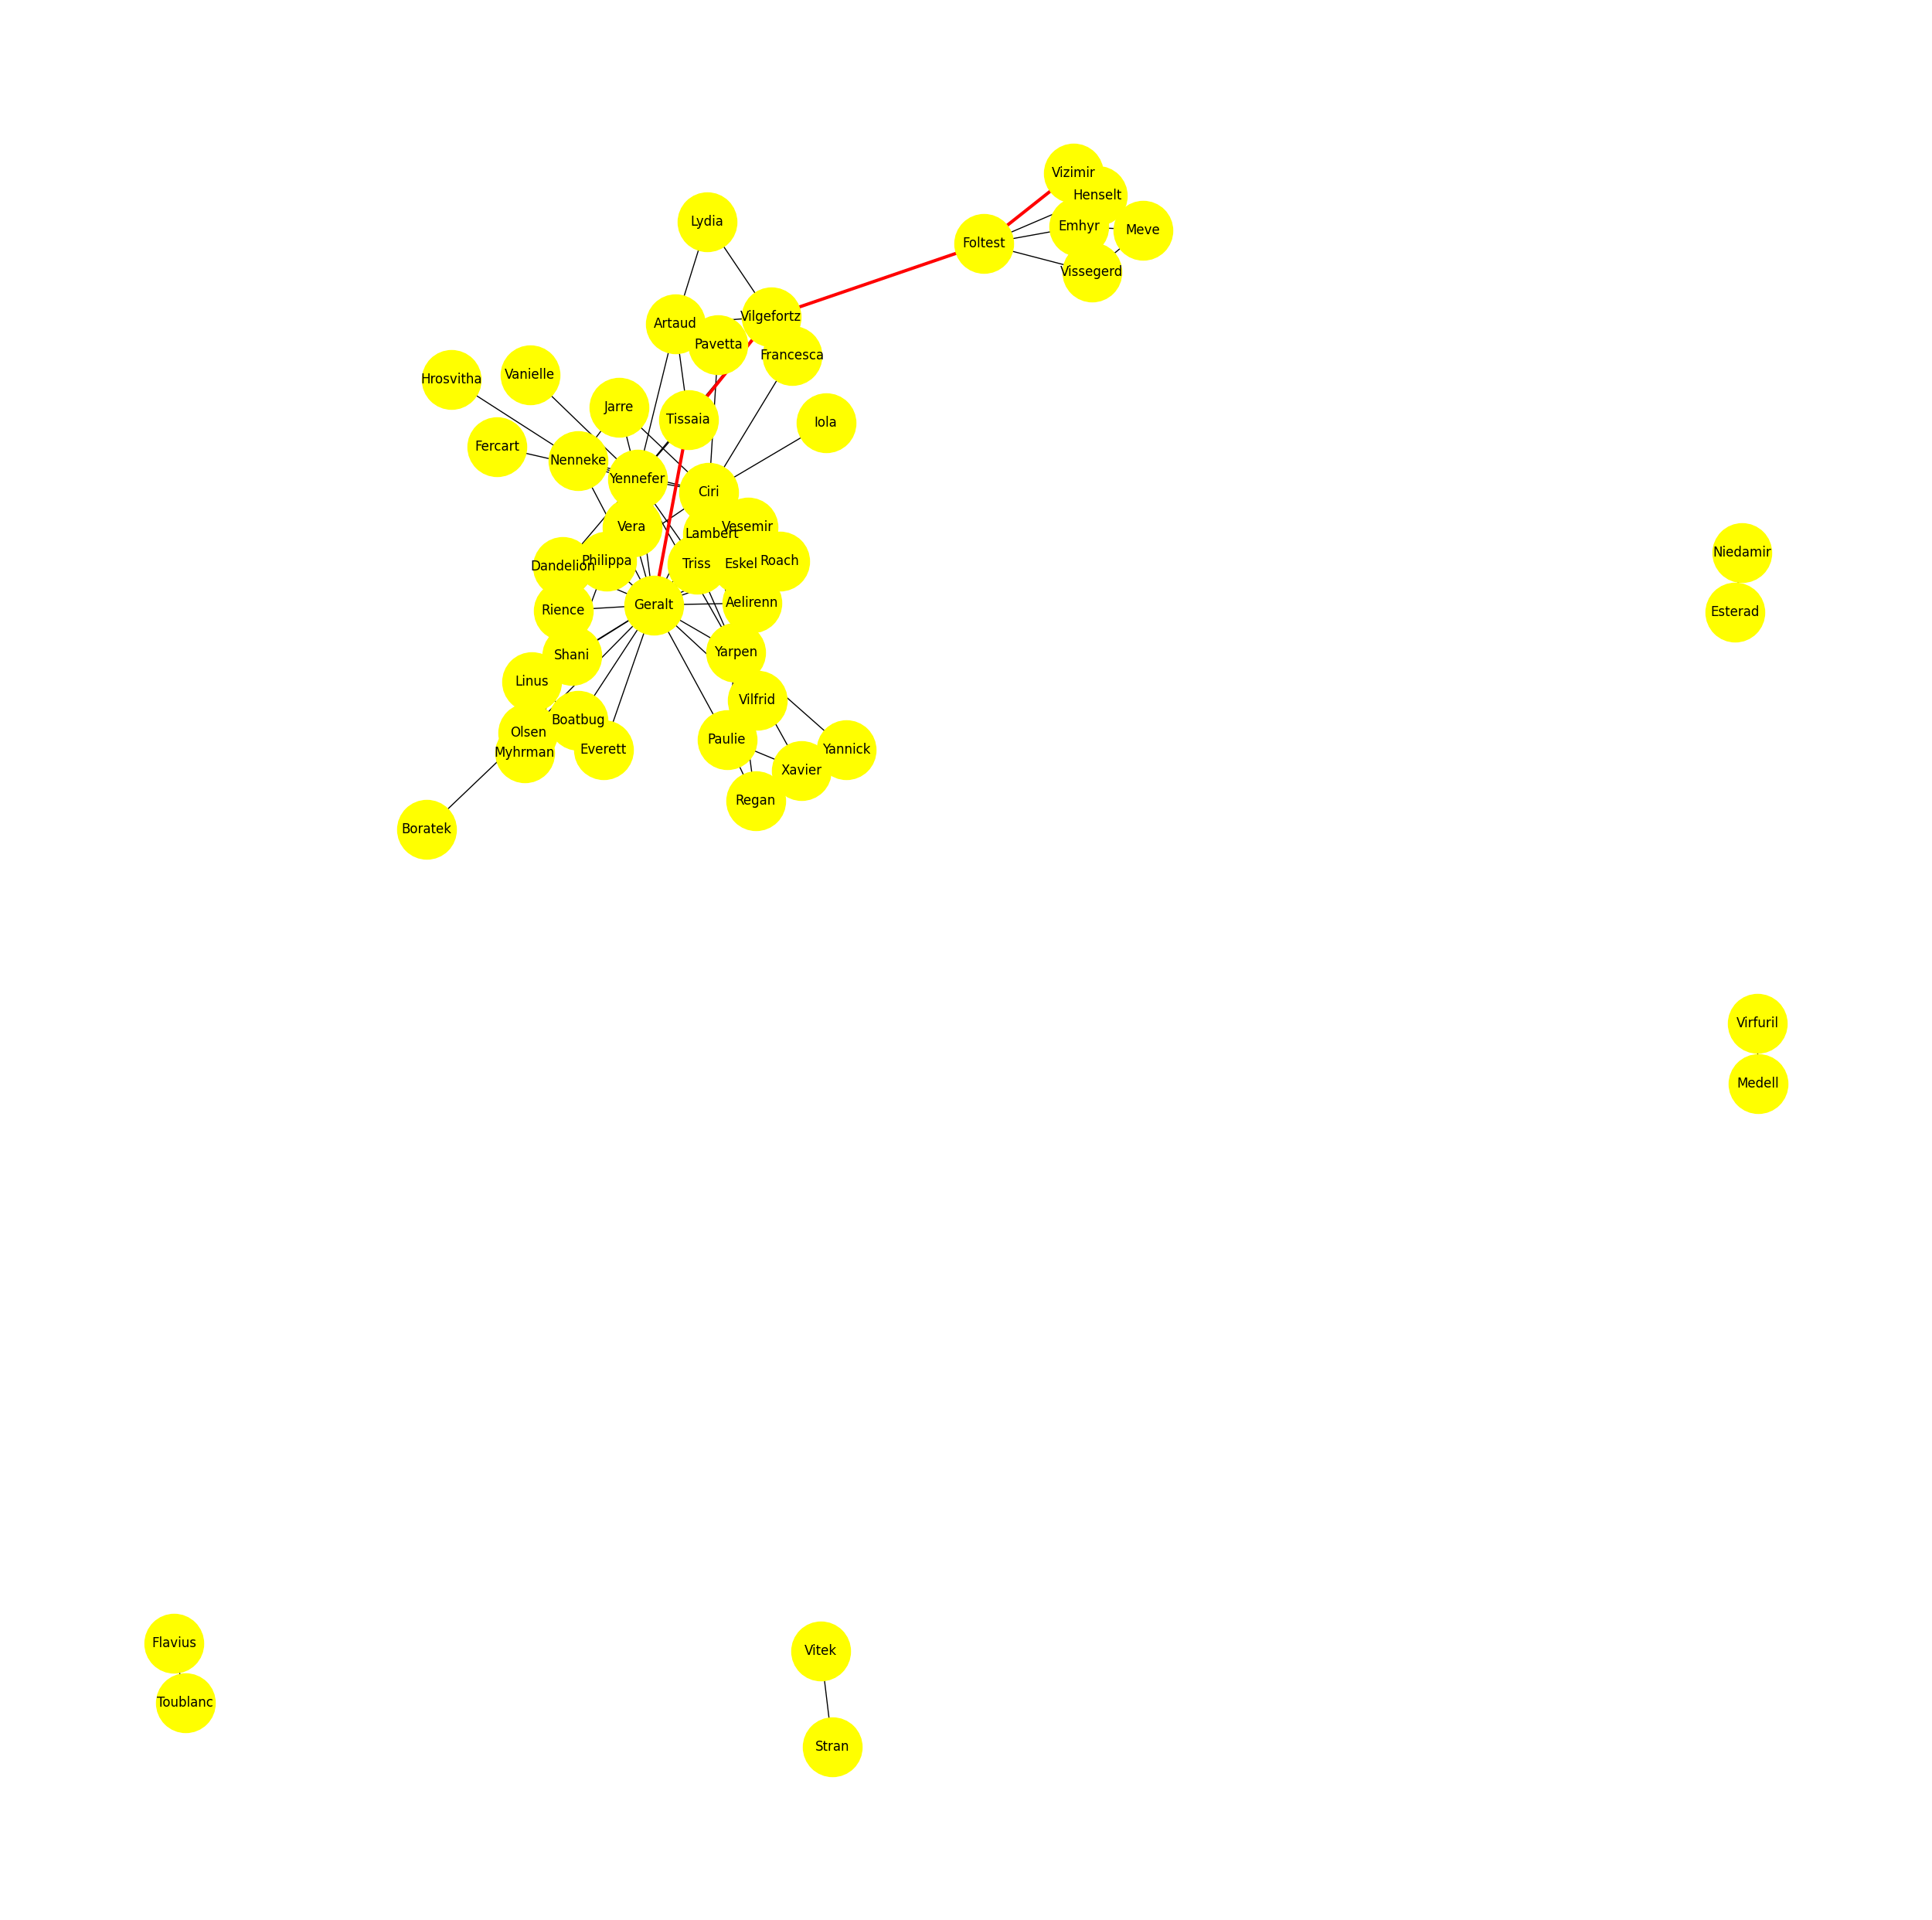

In [73]:
plot_paths(G, [nx.shortest_path(G, source, target)])

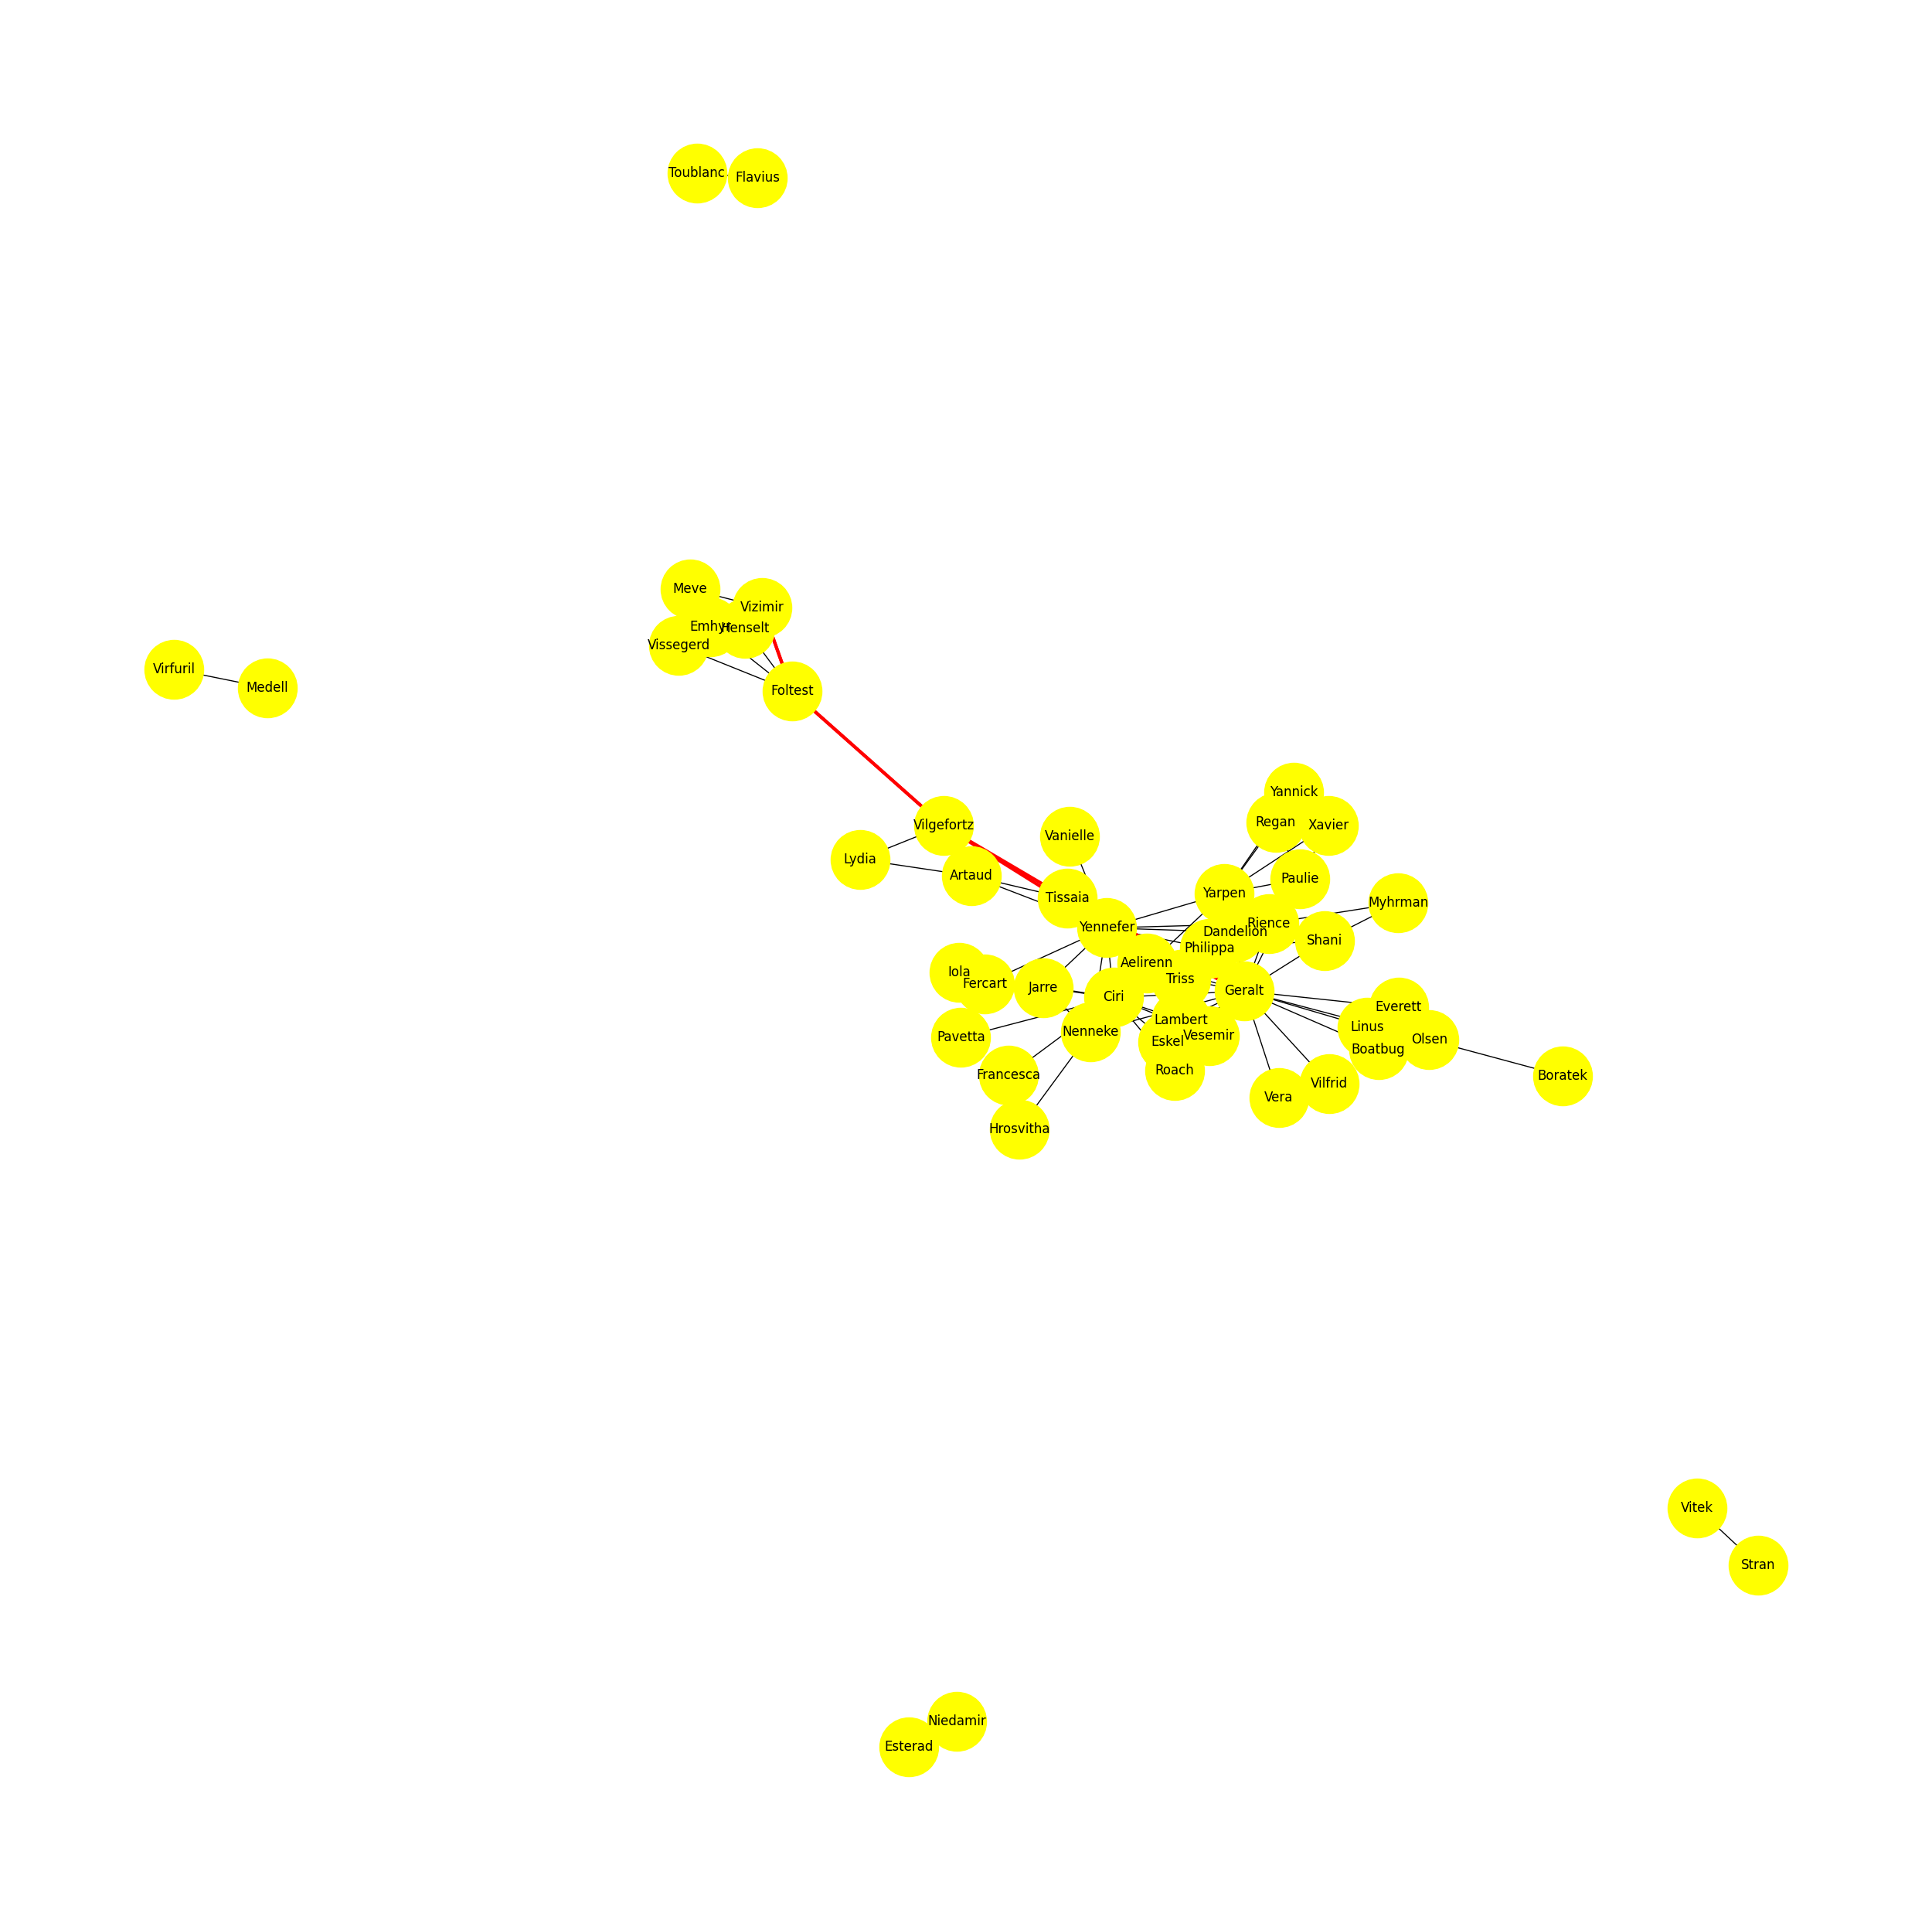

In [74]:
plot_paths(G, nx.all_shortest_paths(G, source, target))

These cells take a long time(hours together ) to run and hence why have been commented down but they basically enumerate through all the paths

In [75]:
# #Generate all simple paths in the graph G from source to target.
# #A simple path is a path with no repeated node
# for i, path in enumerate(nx.all_simple_paths(G, source, target), 1):
#     print(i, path)

In [76]:
#Generate all simple paths in the graph G from source to target,
#starting from shortest ones.
#A simple path is a path with no repeated nodes.
#If a weighted shortest path search is to be used, no negative weights are allowed
# for i, path in enumerate(nx.shortest_simple_paths(G, source, target), 1):
#     print(i, path)

In [77]:
len(r['source'])

100

In [78]:
len(nx.shortest_path(G, source, target))

5

In [79]:
r = relationship_df.sort_values(by=['value'],ascending=False)
G = nx.from_pandas_edgelist(r, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

In [80]:
source1 = r['source'].unique()
target1 = r['target'].unique()


In [81]:
sum = 0
for i in range(len(source1)):
  for j in range(i, len(target1)):
    sum = sum + len(nx.shortest_path(G, source1[i], target1[j]))
avg_shortest_path = sum/(1326) #52C2
print('Average shortest path of graph is: ', avg_shortest_path)

Average shortest path of graph is:  5.039969834087481


# Section 2c


### we have considered Transitivity,Average Clustering,Degree Pearson Correlation coefficient and Diameter as parameters across which we will compare perfomance of 3 models along with the originalGraph, average transitivity depicts how well a character is supporting brokerage role across the modeled graph by exploiting structural hole which exist among it's alters(characters known to them).we can see that with input probability for edge creation of a character (character Geralt knowing Triss)we can get to know the perfomance of the G(n,p) model. 

### Diameter signifies the longest path among all available paths between any 2 characte which tells within how many minimum hops/with passing information to a minimum set of characters how a source can reach destination character characterrs.degree_pearson_correlation_coefficient gives degree assortativity of graph which measures the similarity of connections in the graph with respect to the node degree. 


### from the above G(n,p) model it is evident that preferential model is in alignment with the constructed model where assortativity is in agreement which is given by degree_pearson_correlation_coefficient wherein node with higher degree tends to establish edge connection with similar node which has higher degree and vice-versa

### In the following story, the fact that if Geralt has higher degree then he would tend to form connections/attach with Ciri in closest/shortest path, (who has more degree too) rather than attaching with Foltest who has comparitevly lesser degree than Ciri, so Geralt would like to make bond with Ciri in closest possible way, which follows the concept of "rich tends to mix with richer people".Barbasi Albert model G(n,m) signifies with how many neighbors a node can connect/establish connection with, with the given input the built model was able to give out almost similar clustering coefficient

# Size of largest Component:

In [82]:
a = nx.is_connected(G)
s='\n Is a connected graph: ' +repr(a)
print (s)

no=len(list(nx.connected_components(G)))
s='\n no of connected components: ' +repr(no)
print (s)

#Gecum13ate a sorted list of connected components, largest first 
CoC=sorted(nx.connected_components(G), key = len, reverse=True)
for item in CoC:
    cclen=len(item)
    s= "\n Connected component length:" +repr(cclen)
    print (s)
    print ("\n Connected component :")
    print (item)



 Is a connected graph: True

 no of connected components: 1

 Connected component length:76

 Connected component :
{'Philippa', 'Keira', 'Medell', 'Donimir', 'Tissaia', 'Ethain', 'Radovid', 'Olsen', 'Pavetta', 'Agnes', 'Roach', 'Niedamir', 'Vanielle', 'Emhyr', 'Vitek', 'Paulie', 'Vizimir', 'Milan', 'Menno', 'Stran', 'Schrader', 'Meve', 'Lydia', 'Yannick', 'Boatbug', 'Michelet', 'Giambattista', 'Francesca', 'Boratek', 'Vera', 'Vilfrid', 'Yarpen', 'Eskel', 'Yennefer', 'Lucas', 'Sheldon', 'Geralt', 'Aelirenn', 'Myhrman', 'Gruzila', 'Crach', 'Wolfgang', 'Virfuril', 'Henselt', 'Fercart', 'Nenneke', 'Myrrha', 'Rience', 'Everett', 'Esterad', 'Ithlinne', 'Ori', 'Lodovico', 'Vilgefortz', 'Xavier', 'Essi', 'Lambert', 'Hrosvitha', 'Iola', 'Regan', 'Toublanc', 'Flavius', 'Jarre', 'Vesemir', 'Shani', 'Ciri', 'Triss', 'Axel', 'Eurneid', 'Eist', 'Artaud', 'Dandelion', 'Linus', 'Foltest', 'Vissegerd', 'Mama'}


# We can observe that largest connected component is the one with the size = 45

In [83]:
list(nx.connected_components(G))

[{'Aelirenn',
  'Agnes',
  'Artaud',
  'Axel',
  'Boatbug',
  'Boratek',
  'Ciri',
  'Crach',
  'Dandelion',
  'Donimir',
  'Eist',
  'Emhyr',
  'Eskel',
  'Essi',
  'Esterad',
  'Ethain',
  'Eurneid',
  'Everett',
  'Fercart',
  'Flavius',
  'Foltest',
  'Francesca',
  'Geralt',
  'Giambattista',
  'Gruzila',
  'Henselt',
  'Hrosvitha',
  'Iola',
  'Ithlinne',
  'Jarre',
  'Keira',
  'Lambert',
  'Linus',
  'Lodovico',
  'Lucas',
  'Lydia',
  'Mama',
  'Medell',
  'Menno',
  'Meve',
  'Michelet',
  'Milan',
  'Myhrman',
  'Myrrha',
  'Nenneke',
  'Niedamir',
  'Olsen',
  'Ori',
  'Paulie',
  'Pavetta',
  'Philippa',
  'Radovid',
  'Regan',
  'Rience',
  'Roach',
  'Schrader',
  'Shani',
  'Sheldon',
  'Stran',
  'Tissaia',
  'Toublanc',
  'Triss',
  'Vanielle',
  'Vera',
  'Vesemir',
  'Vilfrid',
  'Vilgefortz',
  'Virfuril',
  'Vissegerd',
  'Vitek',
  'Vizimir',
  'Wolfgang',
  'Xavier',
  'Yannick',
  'Yarpen',
  'Yennefer'}]

Compare with random graph model

In [84]:
nodes=G.number_of_nodes()
nodes

76

In [85]:
#calculate average degree to use with random graph models 

degree_list = list(nx.degree(G))
#print(degree_list)
no_nodes=len(degree_list)
total_degree=0
for node in degree_list[:5]:
    print("Node ", node[0], " : Degree is ", node[1])
    total_degree=total_degree+ node[1]
avg_degree= total_degree/no_nodes
avg_degree

Node  Ciri  : Degree is  30
Node  Yennefer  : Degree is  20
Node  Geralt  : Degree is  36
Node  Triss  : Degree is  11
Node  Yarpen  : Degree is  12


1.4342105263157894

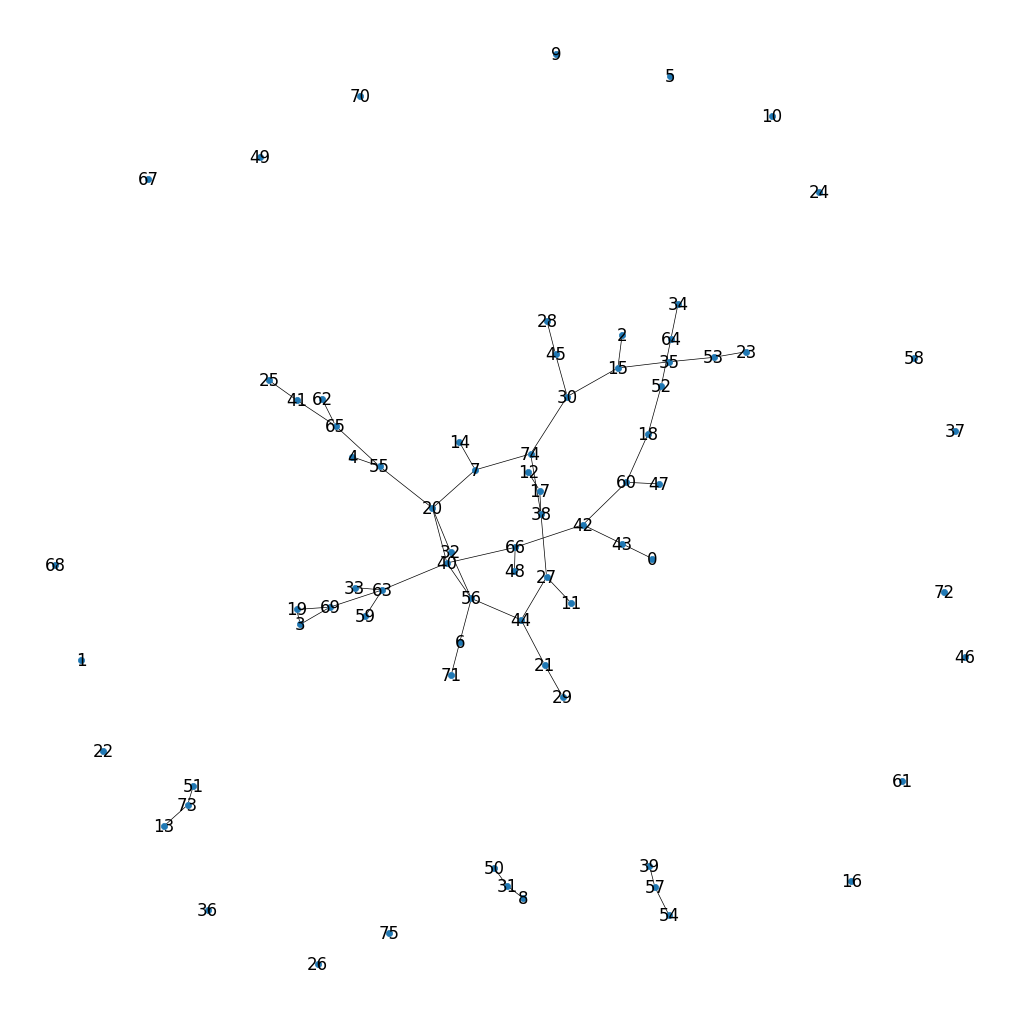

In [86]:
#note that no_nodes-1
p=avg_degree/(no_nodes-1)
#G2 = nx.erdos_renyi_graph(no_nodes,p)  # same call 
G2 = nx.gnp_random_graph(no_nodes,p)
fig = plt.figure(figsize =(10 ,10))
nx.draw(G2, with_labels = True, node_size = 20, linewidths = 0.5, width = 0.5, arrows=True)
plt.show()


G(n,p) random Graph :

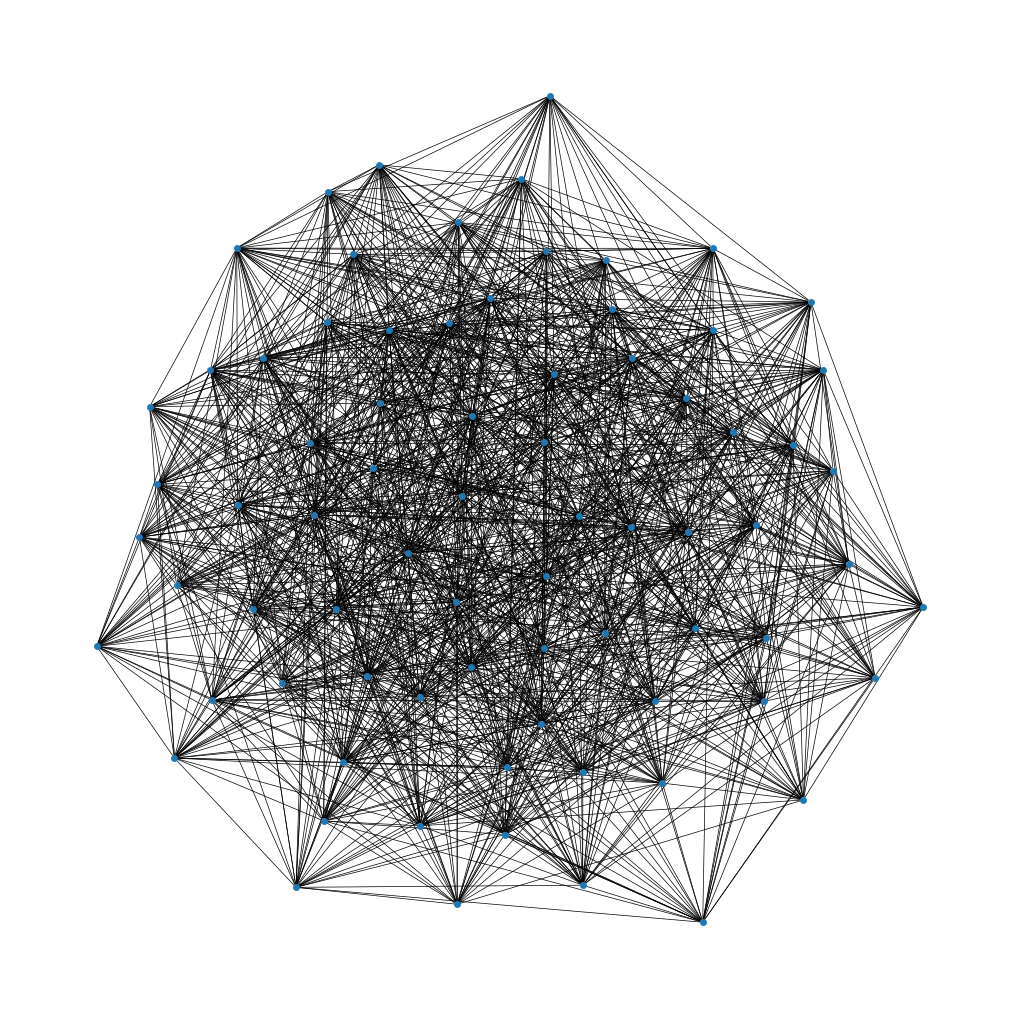

In [87]:
#Make random graph 
G2 = nx.gnp_random_graph(no_nodes,0.45)
#after several trails optimal probability for the graph to have clustering coefficent value similar to original graph was found
fig = plt.figure(figsize =(10 ,10))
nx.draw(G2, with_labels = False, node_size = 20, linewidths = 0.5, width = 0.5, arrows=True)
plt.show()


Barbasis Albert Preferential Attachment G(n,m)

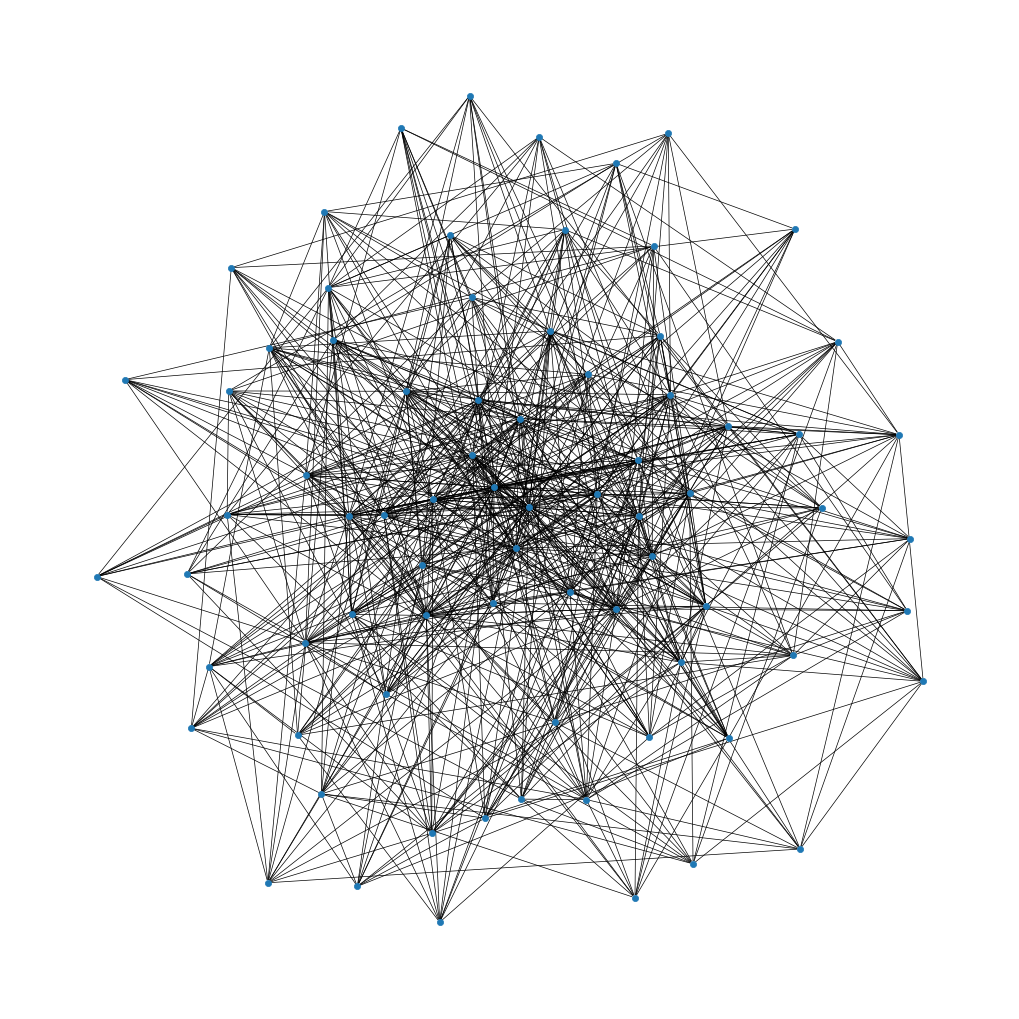

In [88]:
#parameters n (int) – Number of nodes, m (int) – Number of edges to attach from a new node to existing nodes
neighbours=11
H1 = nx.barabasi_albert_graph(no_nodes,neighbours)
fig = plt.figure(figsize =(10 ,10))
nx.draw(H1, with_labels = False, node_size = 20, linewidths = 0.5, width = 0.5,arrows=True)
plt.show()

Watts Strogratz small world model

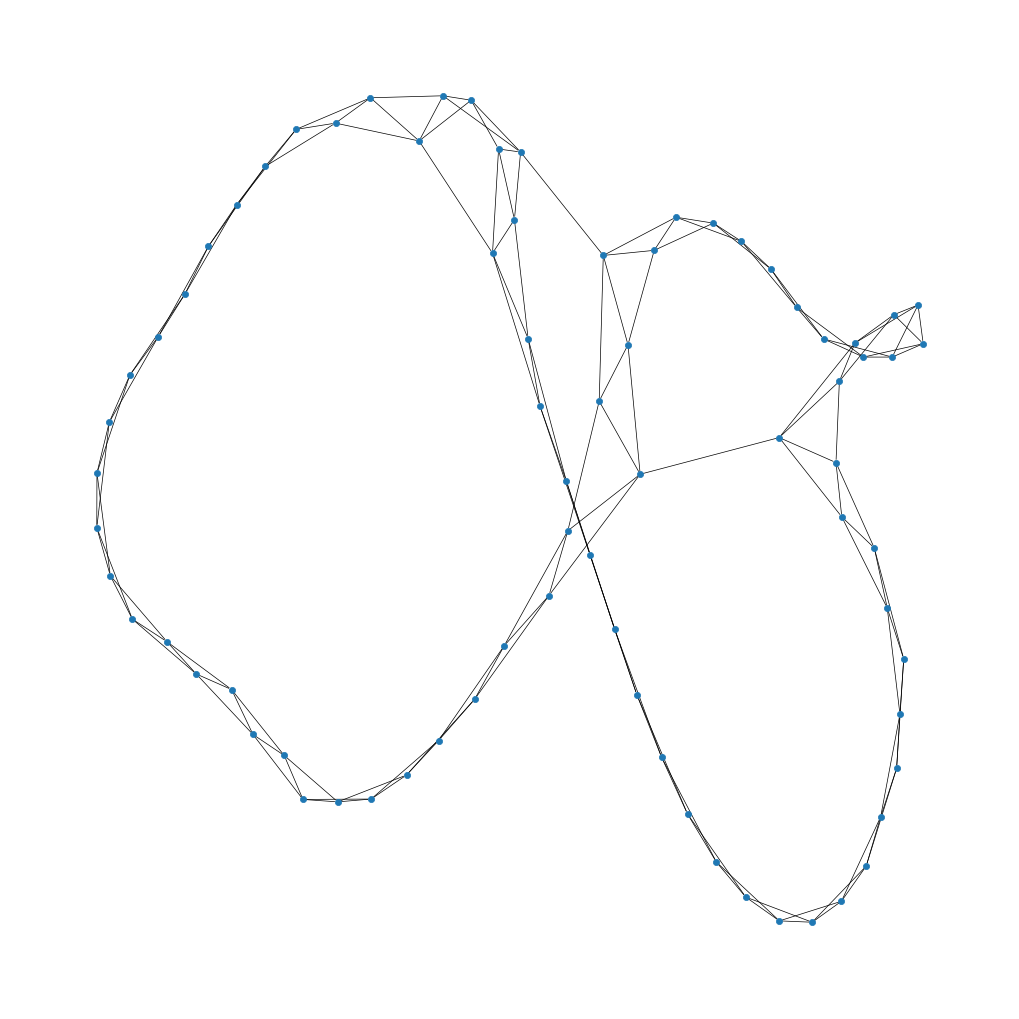

In [89]:
#parameters : n (int) – The number of nodes, (int) – 
# paramters : Each node is joined with its k nearest neighbors in a ring topology
H2 = nx.newman_watts_strogatz_graph(no_nodes,4,p)
fig = plt.figure(figsize =(10 ,10))

nx.draw(H2, with_labels = False, node_size = 20, linewidths = 0.5, width = 0.5,arrows=True)
plt.show()

In [90]:
## Comparing different models with respect to different parameters
Transitivity = [nx.transitivity(G2),nx.transitivity(H1),nx.transitivity(H2),nx.transitivity(G)]
Avg_Clustering = [nx.average_clustering(G2),nx.average_clustering(H1),nx.average_clustering(H2),nx.average_clustering(G)]
Diameter = [nx.diameter(G2),nx.diameter(H1),nx.diameter(H2),10 ] #Diameter of original graph taken from previous calculations
Degree_Pearson_correlation = [nx.degree_pearson_correlation_coefficient(G2),nx.degree_pearson_correlation_coefficient(H1),nx.degree_pearson_correlation_coefficient(H2),nx.degree_pearson_correlation_coefficient(G)]
Graph_Model = ["Random Graph[G(n,p)] model ","Barbasi_albert[G(n,m)]/Preferential model ","Watts_Strogatz/Small World Model","Original Graph"]
zipped = list(zip(Graph_Model,Transitivity,Avg_Clustering,Diameter,Degree_Pearson_correlation))
comp_df = pd.DataFrame(zipped,columns = ['Graph Model','Transitivity','Average Clustering','Diameter','Degree Pearson Correlation Coefficient'])
comp_df

Graph Model  Transitivity  \
0                 Random Graph[G(n,p)] model       0.465673   
1  Barbasi_albert[G(n,m)]/Preferential model       0.325903   
2            Watts_Strogatz/Small World Model      0.475000   
3                              Original Graph      0.287109   

   Average Clustering  Diameter  Degree Pearson Correlation Coefficient  
0            0.464988         2                                0.001580  
1            0.352067         3                               -0.109832  
2            0.484211        14                                0.114286  
3            0.460073        10                               -0.200384

# Section 2b.  
### An indicator of how closely nodes in a graph tend to cluster together is called a clustering coefficient. The network's clustering coefficient is a key factor in determining how the link prediction approach behaves.so for the story chosen, the average clustering coefficient comes out to be 0.45, which signifies that the alters of a particular node say Geralt knows Triss(evident from graph) then the fact that Triss may know any one of the character in entire graph is approximately 45% or with clustering coefficient of 0.45 they both can form a cluster. On the other hand local clustering coefficient signifies how well Geralt's friends/neighbors are interconnected in proportion/ relative to Geralt's total networks with all other neighbors which is given by geralt's local clustering coefficient, From the graph it is evident that some of characters like Boratek, has 0 local clustering coefficient which signifies that he doesn't necessarily carry information/know characters across any 2 given communities say(Geralt and Ciri), hence  our understanding that transitivity is closely related to local clustering coefficient is true, 


### On the other hand Nenneke has local clustering coefficient of '0.8' which signifies that he carries information from one community to the other in a flow (in this case, across Geralt,Ciri,Yennefer communities) it can be shown that he knows most of neighbors of these communities irrespective of his distance with other characters whilst Boratek knows only Olsen who is a part of Geralt community,but Boratek doesn't have contact with others, and is all alone in his way.Transitivity defines how well brokerage role can be introduced to acheive relationship amongst 2 alters by exploiting structural hole between the alters, so transitivity of Triss is also high, the reason for this is that he is not connected to any nodes that have a local clustering coeffiecent of 0. Coming to detected communities there are 7 different communities detected from the graph based on neighborhood/how good any 2 given characters interact, the closer the nodes, they tend to form a community for example Geralt and ciri has their own communities because of their degree centralities, Communities are mainly formed based on degree of a particular node/character and distance amogst 2 characaters .


### If 2 characters, say Geralt and Ciri have most degree(characters known by Geralt who frequently interact with him) and Ciri who has similar case, but geralt and Ciri have the highest edge weight(as they appear together in the story the most) this indicates that their followers (edges with other characters) are quite different and hence  they both along with their interactive characters/neighbors form their respective communities.Ego network of protagonists clearly shows that they form their own community where characters known by them (alters) are densely connected amongst themselves or connected across other set for alters, so they tend to dictate any information/relationship attributes across their community which forms major part of entire Graph.Average shortest paths between any 2 characters depict the average path length/hops of all possible shortest paths from given source to destination, we can see that average shortest path value = 5, which signifies that with minimum of 5 hops a character(source) can reach other character(destination). That is quite reasonable considering that there are 52 nodes in the graph with 100 total edges

## Let's check how similar 2 characters are

In [91]:
%pip install node2vec
from node2vec import Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\shubh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Computing transition probabilities: 100%|██████████| 76/76 [00:00<00:00, 3482.65it/s]


In [92]:
#it uses word2vec
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [93]:
model.wv.get_vector('Geralt')

array([ 0.27587706, -0.03180303,  0.17577489,  0.15245686, -0.07404484,
       -0.11920524,  0.24100927,  0.14592619,  0.04043913,  0.05745549,
       -0.01670761, -0.20273565, -0.12012403, -0.12135136, -0.18119313,
        0.10689916,  0.04495951, -0.11860583, -0.15600066,  0.11257818,
        0.3120998 ,  0.14362508,  0.31127417,  0.1346579 ,  0.05275724,
        0.07580817,  0.04361609,  0.05352139,  0.06647734,  0.06127653,
       -0.14835364,  0.06632189, -0.07519418, -0.26892003, -0.1452015 ,
       -0.24193023,  0.05094161, -0.03290486,  0.11340194, -0.06795803,
        0.03614477,  0.04478678,  0.09608497, -0.0652667 , -0.09547587,
       -0.02210945,  0.11098538,  0.16359593,  0.0712791 ,  0.17200302,
       -0.16096234, -0.08201939,  0.05246658, -0.13848737, -0.00301587,
        0.09274072,  0.10760386, -0.1410054 , -0.05534757,  0.07589104,
        0.01773767, -0.0354364 , -0.05418729, -0.23252374], dtype=float32)

In [94]:
model.wv.most_similar('Geralt')

[('Everett', 0.5353955626487732),
 ('Radovid', 0.5312053561210632),
 ('Lucas', 0.53044593334198),
 ('Olsen', 0.5275072455406189),
 ('Vitek', 0.5253452062606812),
 ('Vilfrid', 0.5104945302009583),
 ('Linus', 0.5027880668640137),
 ('Yarpen', 0.49652060866355896),
 ('Boatbug', 0.4952302873134613),
 ('Aelirenn', 0.4936302602291107)]

## To handle missing edge : 

In [95]:
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [96]:
edges_embs[('Geralt', 'Linus')]

array([ 6.89284205e-02,  3.57455085e-03,  4.50432263e-02, -1.92521438e-02,
        7.26017263e-03, -3.42880189e-03,  3.33792530e-02,  2.95599527e-03,
        6.74644858e-03,  2.73504341e-03, -4.68624337e-03,  1.34046739e-02,
        2.91339383e-02, -1.09767104e-02, -2.35022623e-02,  8.78367666e-03,
        1.15818875e-02,  4.74005751e-02,  5.93311079e-02, -2.36143060e-02,
        2.92359926e-02,  2.35120449e-02,  1.09742709e-01, -1.64238419e-02,
        6.09397842e-03,  1.11692399e-02,  1.14360703e-02,  1.56138383e-03,
       -3.03371437e-02,  1.00991852e-03,  2.63966732e-02, -2.47185845e-02,
        2.56929104e-03,  4.46106754e-02,  5.34506552e-02,  1.13943756e-01,
        1.57094188e-02, -6.66267471e-03,  3.01170480e-02,  1.73419490e-02,
       -6.33558026e-03, -7.04748835e-03, -1.44449193e-02,  8.72359797e-03,
       -7.86215905e-03,  3.72893596e-03, -9.86880437e-03,  2.12315042e-02,
        4.61648405e-03,  3.61279286e-02,  3.19941863e-02,  2.17604712e-02,
       -1.29493354e-02, -

In [97]:
#This can be used for missing edge prediction 

edges_kv = edges_embs.as_keyed_vectors()
edges_kv.most_similar(str(('Geralt', 'Linus')))

Generating edge features: 100%|██████████| 2926/2926.0 [00:00<00:00, 138211.99it/s]


[("('Everett', 'Geralt')", 0.9056920409202576),
 ("('Geralt', 'Olsen')", 0.8667531609535217),
 ("('Geralt', 'Vitek')", 0.8625643253326416),
 ("('Boatbug', 'Geralt')", 0.8511170148849487),
 ("('Boratek', 'Geralt')", 0.8099390268325806),
 ("('Geralt', 'Geralt')", 0.7467905282974243),
 ("('Geralt', 'Stran')", 0.7310227155685425),
 ("('Geralt', 'Radovid')", 0.7165522575378418),
 ("('Everett', 'Linus')", 0.6719453930854797),
 ("('Linus', 'Radovid')", 0.6575647592544556)]

### Evolution of characters' importance

Now Here what we've done is Calculate the character's importance (character arc basically) throughout all the books. 

Since we were told to only work with one novel, these cells have been commented out but the final character arc graph  across the 8 Witcher books of the main characters is still shown as an Image from taking all the books 

In [98]:
#%pip install utils

In [99]:
##from lib.utils.functions import *

In [100]:
# # Initialize empty list for graphs from books
# books_graph = []
# all_books = [b for b in os.scandir('data') if '.txt' in b.name]
# # Load spacy English languague model
# nlp = spacy.load("en_core_web_sm")

# # Sort dir entries by name
# all_books.sort(key=lambda x: x.name)

In [101]:
# # Loop through book list and create graphs
# for book in all_books:
#     book_text = ner(book)
    
#     # Get list of entities per sentences
#     sent_entity_df = get_ne_list_per_sentence(book_text)
    
#     # Select only character entities
#     sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

#     # Filter out sentences that don't have any character entities
#     sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
#     # Take only first name of characters
#     sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
#                                                                                                                for item in x])

#     # Create relationship df
#     relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
#     # Create a graph from a pandas dataframe
#     G = nx.from_pandas_edgelist(relationship_df, 
#                                 source = "source", 
#                                 target = "target", 
#                                 edge_attr = "value", 
#                                 create_using = nx.Graph())     
    
#     books_graph.append(G) 

In [102]:
# # Creating a list of degree centrality of all the books
# evol = [nx.degree_centrality(book) for book in books_graph]

# # Creating a DataFrame from the list of degree centralities in all the books
# degree_evol_df = pd.DataFrame.from_records(evol)


# # Plotting the degree centrality evolution of 5 main characters
# degree_evol_df[["Geralt", "Ciri", "Yennefer", "Dandelion", "Vesemir"]].plot()

![Alt text](data/WhatsApp%20Image%202023-03-10%20at%2023.51.14.jpg)